<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Pro/AI_HW4_woodenML_pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание 4 (pro): древесные алгоритмы**

### **Постановка задач**

### **Домашнее задание состоит из двух подзадач:**

**1. В  разделе 1 ваша задача:**
-  реализовать свое решающее дерево
- сравнить его со стандартной имплементацией из sklearn

Функции и классы дерева вы должны оформить в модуль `hw4_code_pro.py`.

**2. В разделе два ваша задача:** решить задачу бинарной классификации при помощи написанного Вами дерева, а также леса из sklearn, а после интерпретировать лучшие модели. Чуть точнее

- Извлечь данные из базы данных;
- Предобработать датасет;
- Обучить собственный класс DT, а также RF из `sklearn` в как базовом варианте (гиперпараметры по умолчанию), так и с подбором гиперпараметров;
- Интерпретировать алгоритмы при помощи LIME или SHAP.


### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**
- Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов.
- Неэффективная реализация кода может негативно отразиться на оценке.

### **Формат сдачи:**
Задания сдаются через  anytask. Посылка должна содержать:
* Ноутбук в формате ipynb
* Модуль hw4_code_pro.py


### **Баллы:**

Суммарно за задание можно получить 10 основных баллов и 1 бонусный балло.

Оценка за ДЗ = min{ваш балл, 10}

Мягкий дедлайн: 27 января 23:59

**Продуктивной и интересной вам работы!**


In [ ]:
!pip install optuna
!pip install lime
!pip install shap
!pip install psycopg2-binary

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')

import psycopg2
import psycopg2.extras

import shap
import lime
import lime.lime_tabular

import optuna

import pickle

import warnings
warnings.filterwarnings('ignore')

# **1. Решающие деревья своими руками (6 баллов)**

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

Всего за часть вы можете получить 6 основных баллов и 1 бонусный.

### **Задание 1. (1 балл)**

Реализуйте функцию find_best_split из модуля hw4_code_pro.py

In [3]:
# Заполните код в модуле
import timeit

In [111]:
import numpy as np
from collections import Counter

def find_best_split(feature_vector, target_vector):
    """
    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    """
    feature_vector = np.array(feature_vector)
    target_vector = np.array(target_vector)
    
    length = len(feature_vector) 
    indices = np.argsort(feature_vector)
    feature_vector = feature_vector[indices]
    target_vector =  target_vector[indices]
    
    thresholds= []
    ginis = []
    minimum_split = []
    
    thresholds_cand = pd.DataFrame(feature_vector).rolling(window=2).mean() # смотрим thresholds со второго элемента
    
    thresholds_cand = np.array(thresholds_cand[1:][thresholds_cand.columns[0]])

    for i in thresholds_cand:
        t_f = feature_vector < i
        L = sum(t_f)
        R = length - L
        if (L == 0) or (R == 0):
            continue
        thresholds.append(i)
        minimum_split.append(min(R, L))
        L_true = sum(target_vector[t_f])
        R_true = sum(target_vector[np.logical_not(t_f)])
                
        H_l = 1 - (L_true/L)**2 - ((L-L_true)/L)**2
        H_r = 1 - (R_true/R)**2 - ((R-R_true)/R)**2
        g = -L*H_l/length - R*H_r/length
        ginis.append(g)
        if len(ginis) == 1:
            threshold_best = i
            gini_best = g
            minimum_split_best = min(R, L)
        else:
            if g > gini_best:
                threshold_best = i
                gini_best = g
                minimum_split_best = min(R, L)
            elif (g == gini_best) and (min(R, L) < minimum_split_best):
                threshold_best = i
                gini_best = g
                minimum_split_best = min(R, L)
    
    
    if len(ginis) == 0:
        return 'no_gini'
    return (thresholds, ginis,  threshold_best, gini_best)

### **Задание 2. (0.25 балла)**

Загрузите таблицу [students.csv](https://github.com/AnastasiyaMax/MLDS_ml_course_fall21/blob/main/hw/hw5_trees/students.csv). Это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling).

В наборе данных:
- признаки объекта записаны в первых пяти столбцах;
- в последнем записана целевая переменная (класс: 0 или 1).

По этим данным, используя функцию из задания 1, постройте:
- пять кривых "порог — значение критерия Джини" для всех пяти признаков;
- scatter-графики "значение признака — класс" для всех пяти признаков;

In [206]:
# Ваш код здесь
df = pd.read_csv('students.csv')
df


STG   SCG   STR   LPR   PEG  UNS
0    0.00  0.00  0.00  0.00  0.00    0
1    0.08  0.08  0.10  0.24  0.90    1
2    0.06  0.06  0.05  0.25  0.33    0
3    0.10  0.10  0.15  0.65  0.30    1
4    0.08  0.08  0.08  0.98  0.24    0
..    ...   ...   ...   ...   ...  ...
253  0.61  0.78  0.69  0.92  0.58    1
254  0.78  0.61  0.71  0.19  0.60    1
255  0.54  0.82  0.71  0.29  0.77    1
256  0.50  0.75  0.81  0.61  0.26    1
257  0.66  0.90  0.76  0.87  0.74    1

[258 rows x 6 columns]

In [208]:
df.shape

(258, 6)

In [210]:
df.loc[:, 'STG']

0      0.00
1      0.08
2      0.06
3      0.10
4      0.08
       ... 
253    0.61
254    0.78
255    0.54
256    0.50
257    0.66
Name: STG, Length: 258, dtype: float64

In [212]:
df.describe()

STG         SCG         STR         LPR         PEG         UNS
count  258.000000  258.000000  258.000000  258.000000  258.000000  258.000000
mean     0.371860    0.356124    0.468023    0.432713    0.458527    0.585271
std      0.210093    0.211801    0.245926    0.248108    0.255217    0.493633
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000
25%      0.240000    0.210000    0.292500    0.250000    0.250000    0.000000
50%      0.330000    0.305000    0.490000    0.330000    0.500000    1.000000
75%      0.500000    0.497500    0.690000    0.647500    0.660000    1.000000
max      0.990000    0.900000    0.950000    0.990000    0.930000    1.000000

In [11]:
%%timeit 
features = df.columns[:-1]
features

7.02 μs ± 434 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


признак STG: threshold_best = 0.615, gini_best = -0.4539770750441065


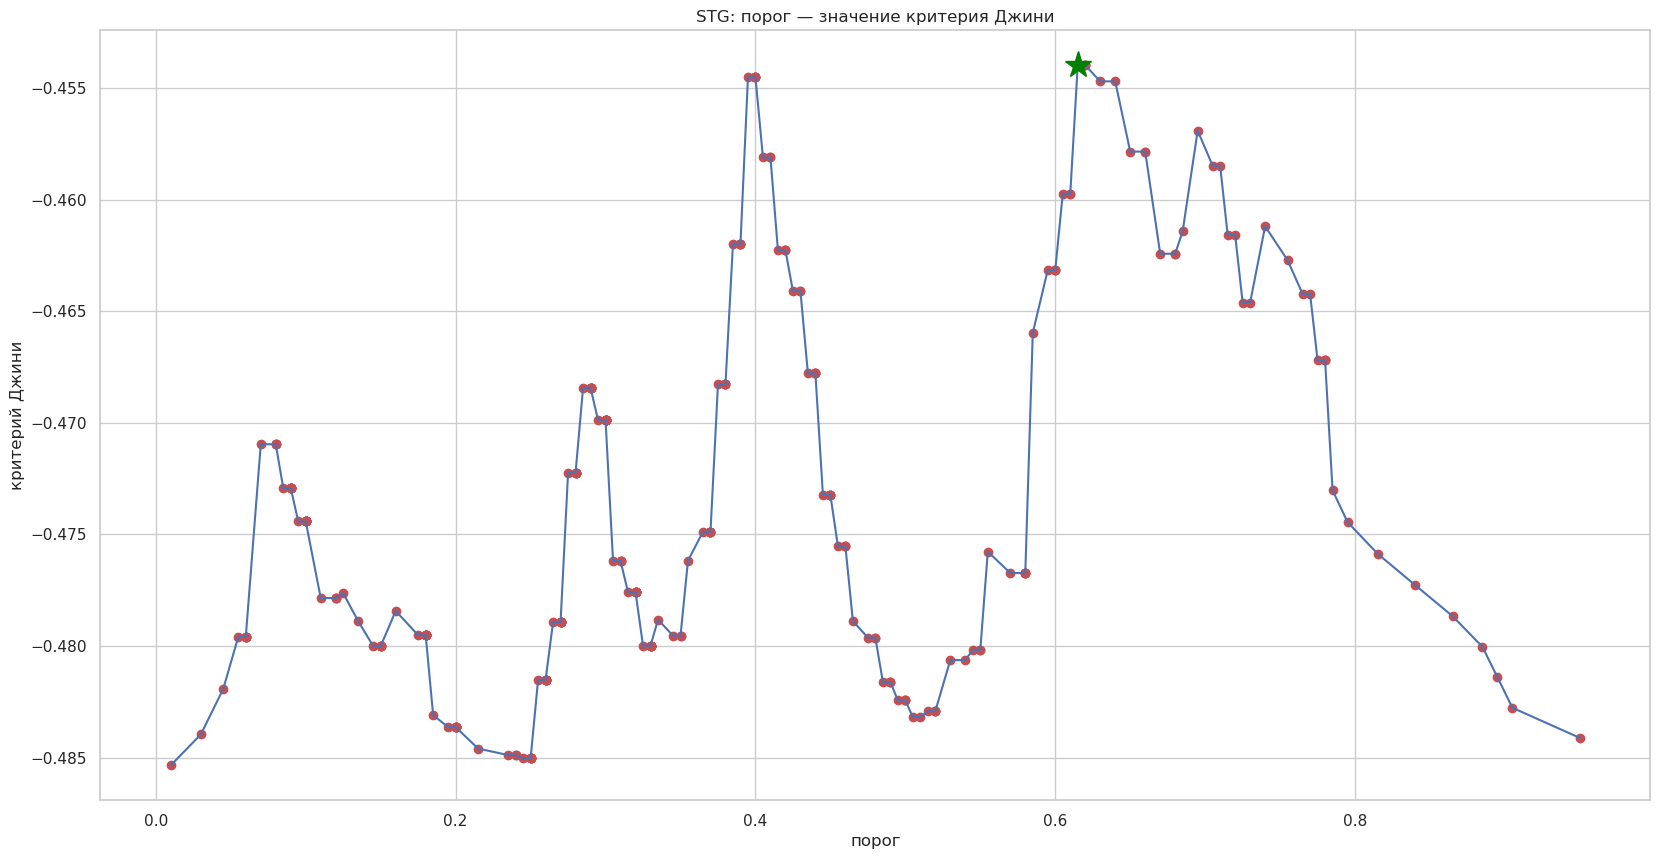

признак SCG: threshold_best = 0.425, gini_best = -0.46501949804018416


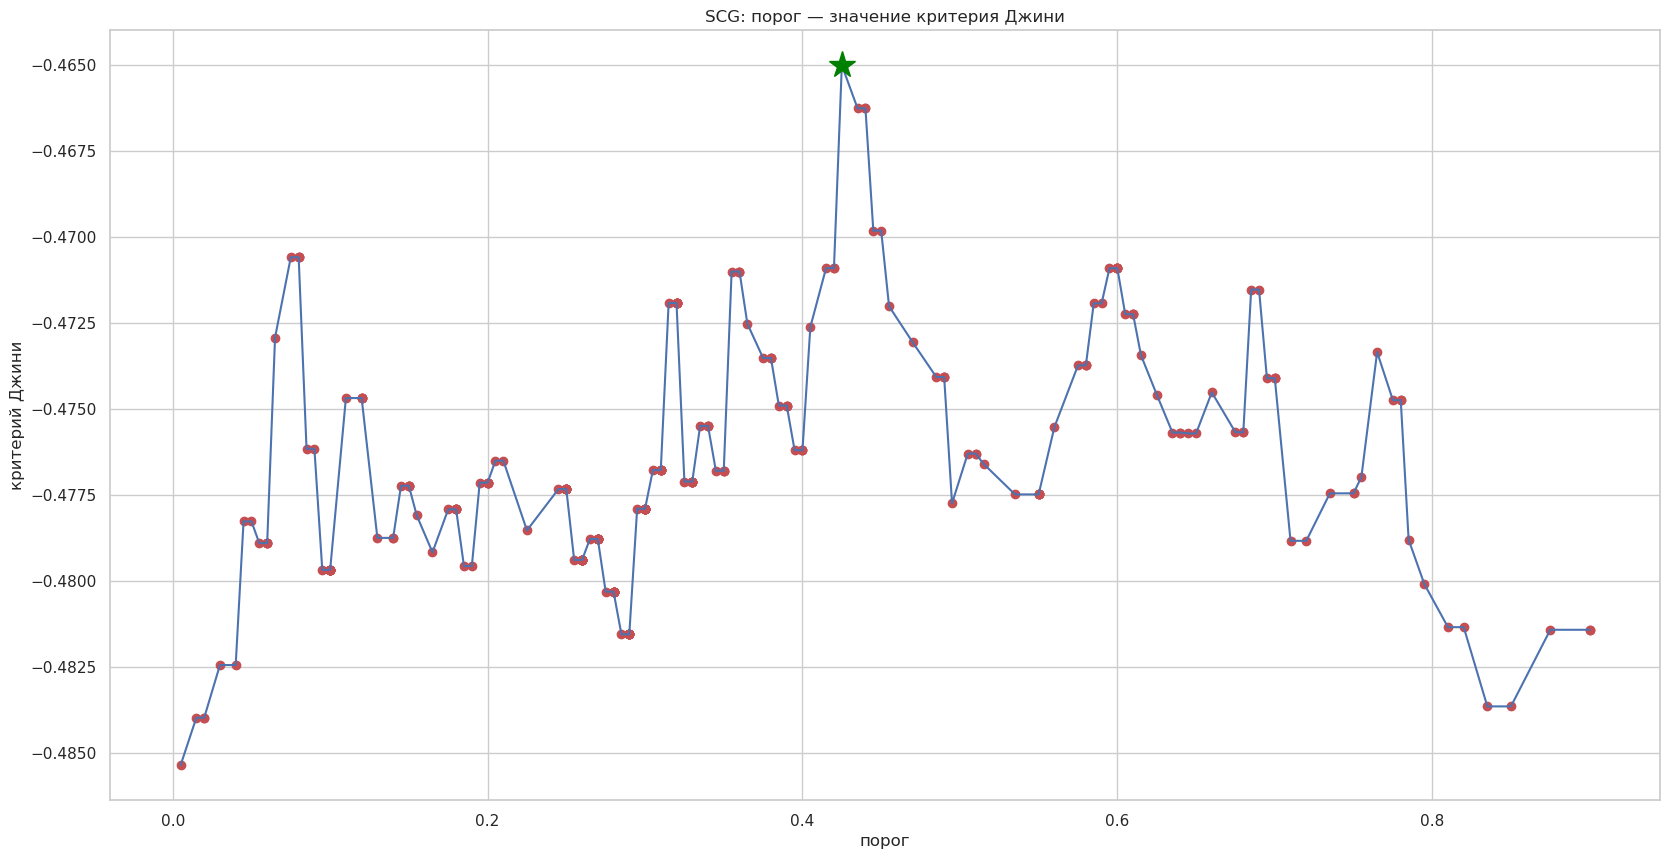

признак STR: threshold_best = 0.365, gini_best = -0.46733829445545116


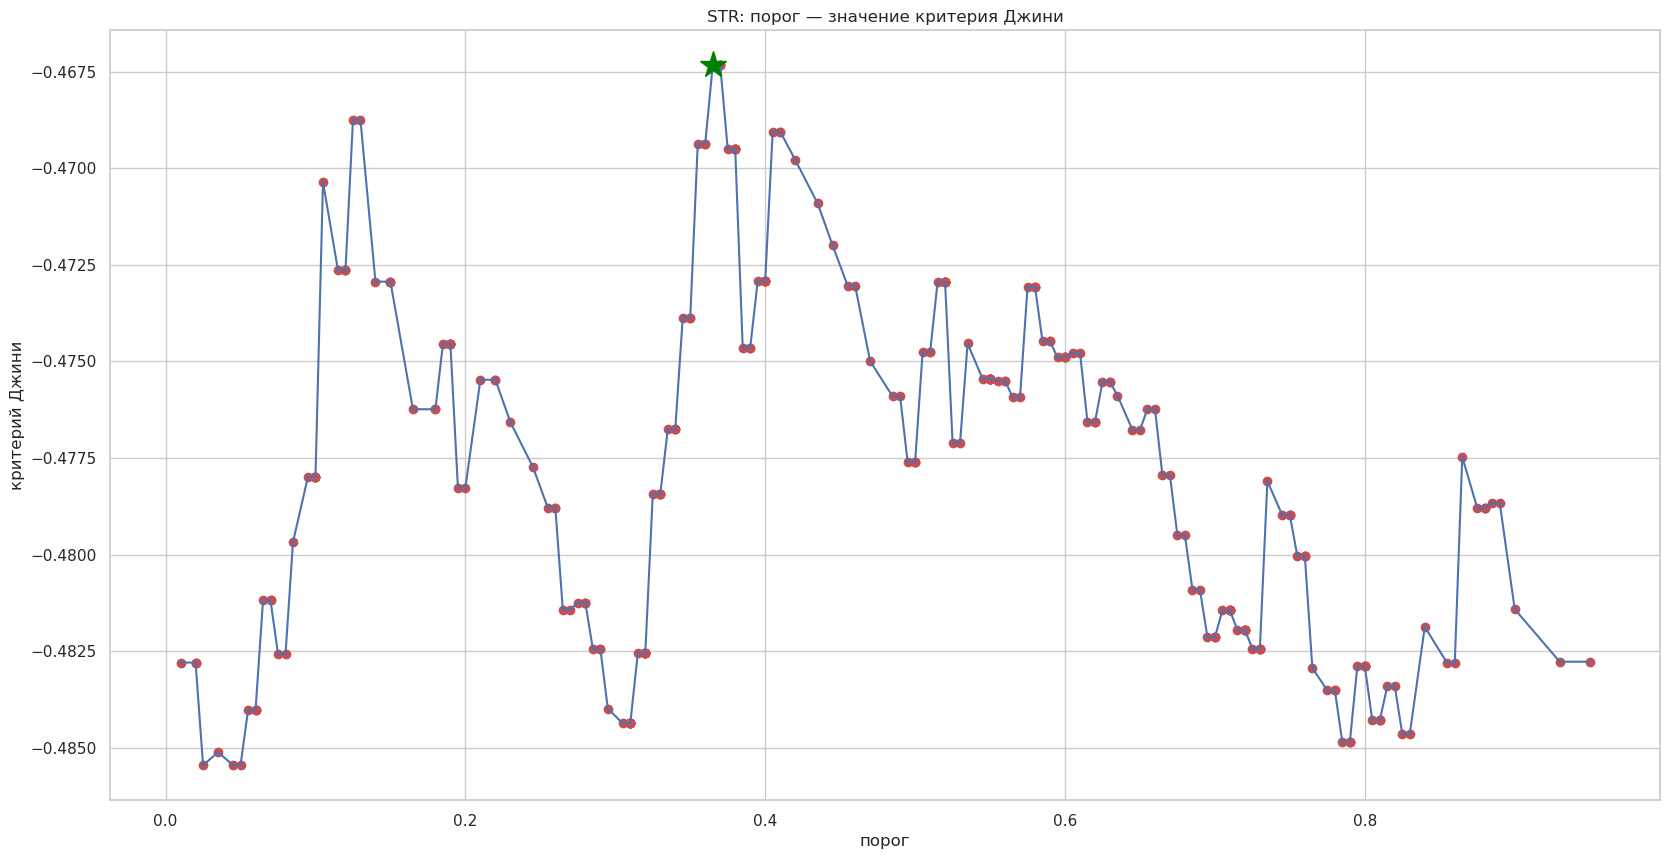

признак LPR: threshold_best = 0.39, gini_best = -0.45466831929301205


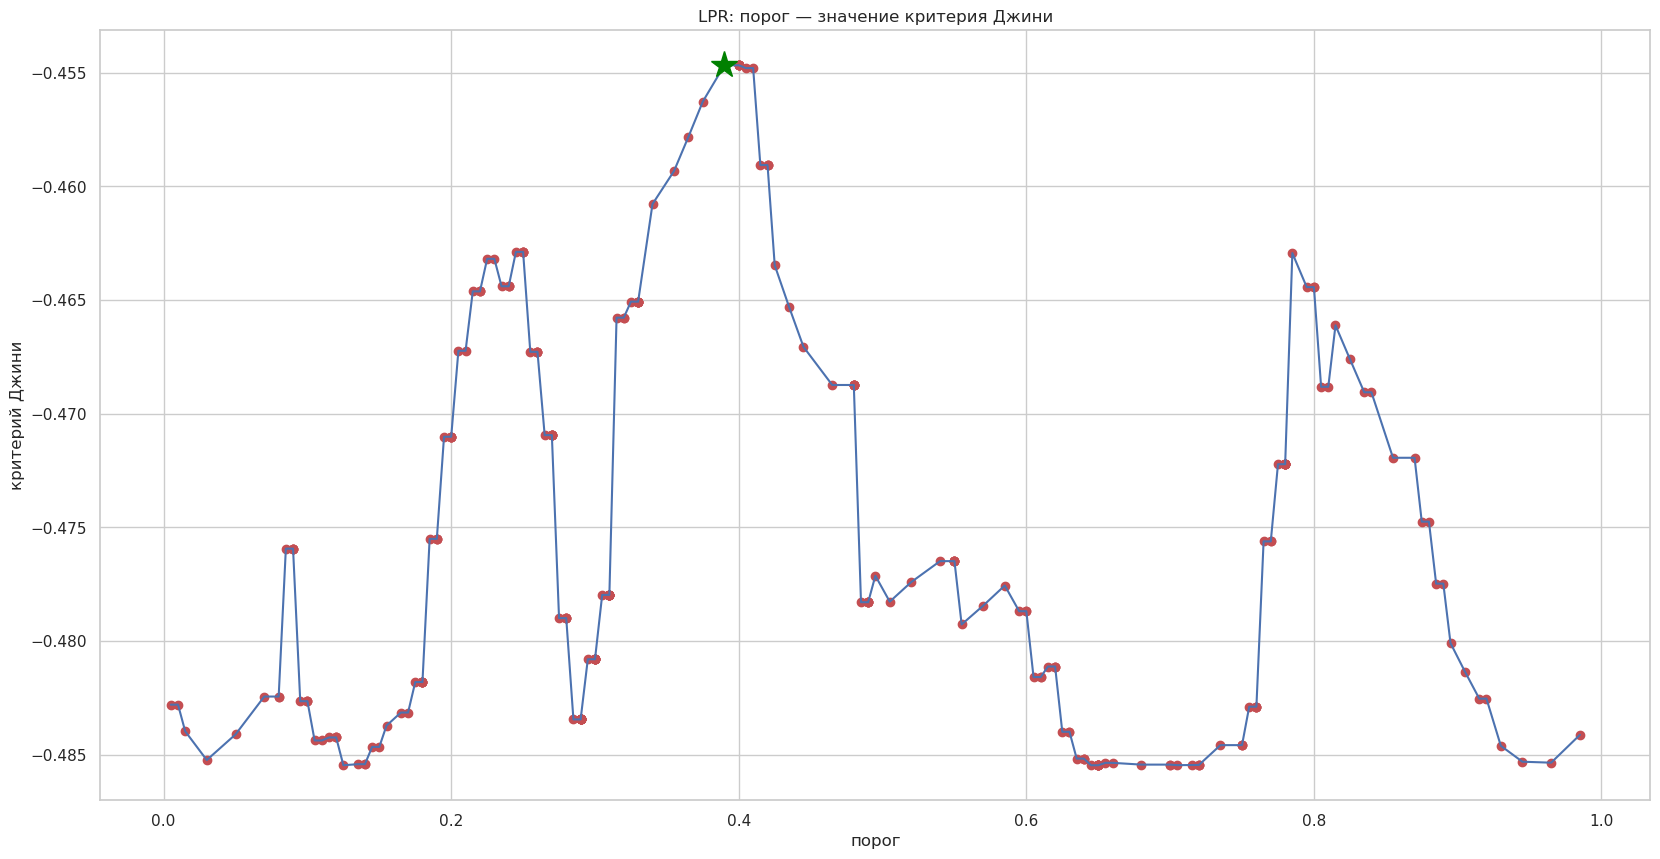

признак PEG: threshold_best = 0.335, gini_best = -0.08606560274912149


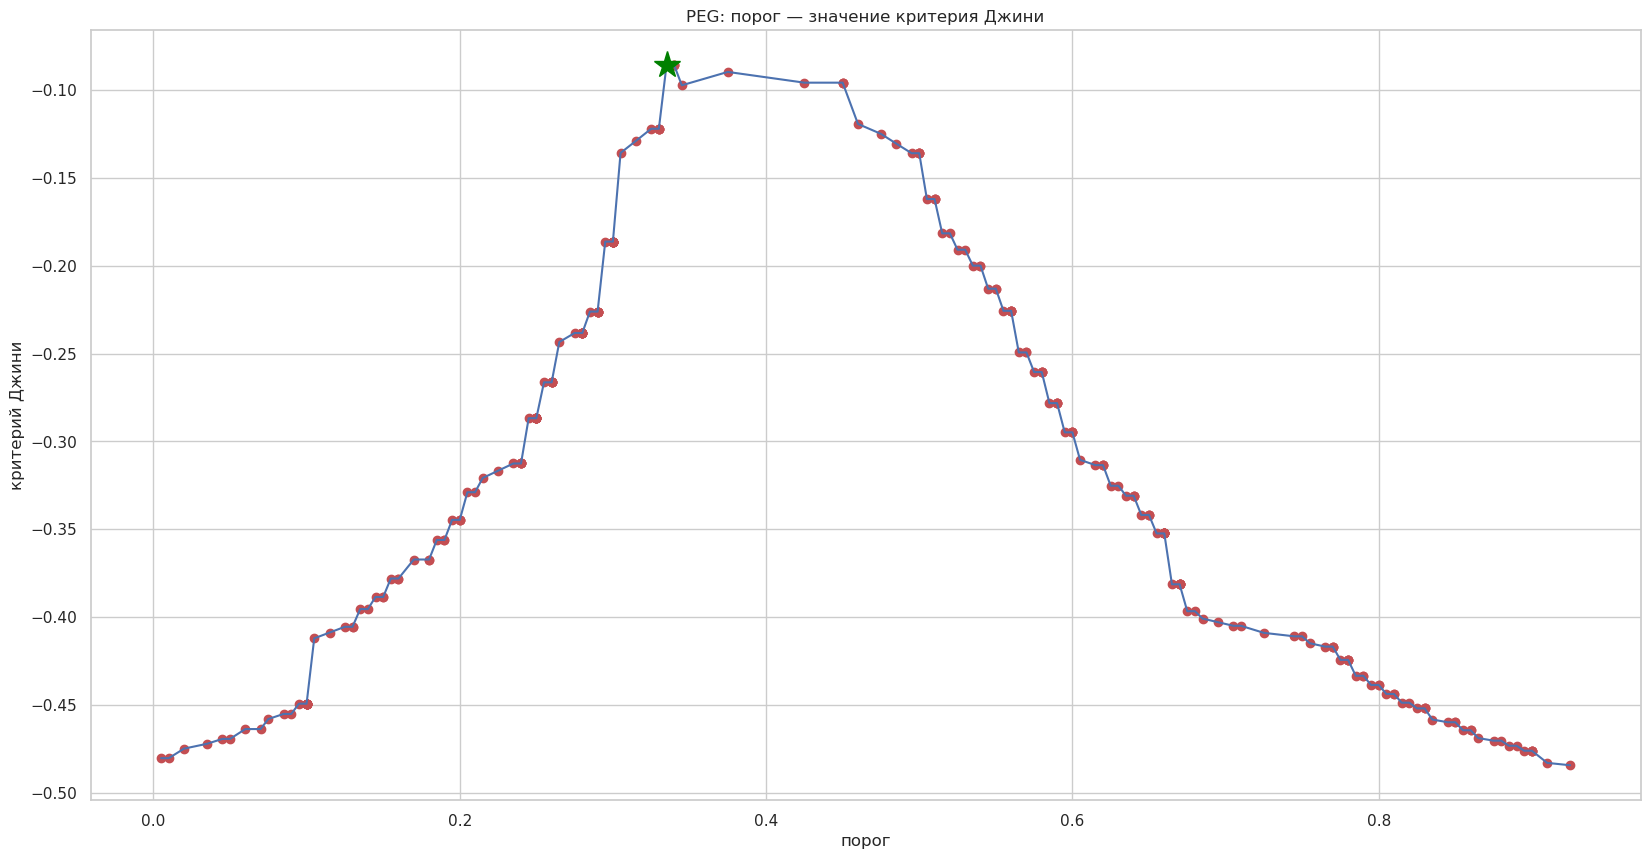

In [216]:
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

for f in features:
    feature_vector = df[f]
    target_vector = df['UNS']
    thresholds, ginis,  threshold_best, gini_best = find_best_split(feature_vector, target_vector)
    print(f"признак {f}: threshold_best = {threshold_best}, gini_best = {gini_best}")
    plt.figure(figsize=(20, 10))
    plt.plot(thresholds, ginis, 'or')
    plt.plot(thresholds, ginis)
    plt.plot(threshold_best, gini_best, marker="*", ms = 20, color = "green")

    plt.title(f"{f}: порог — значение критерия Джини")
    plt.xlabel('порог')
    plt.ylabel('критерий Джини')
    plt.show()

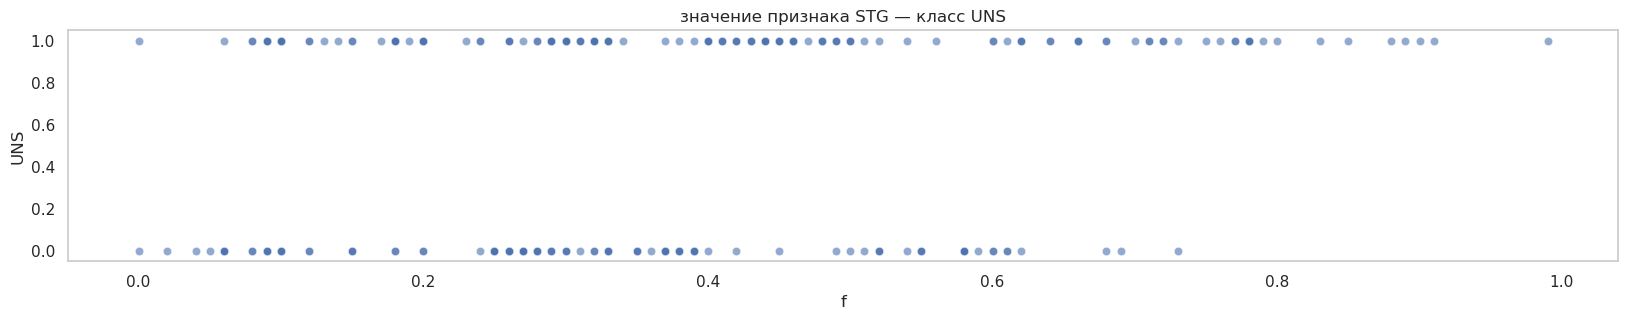

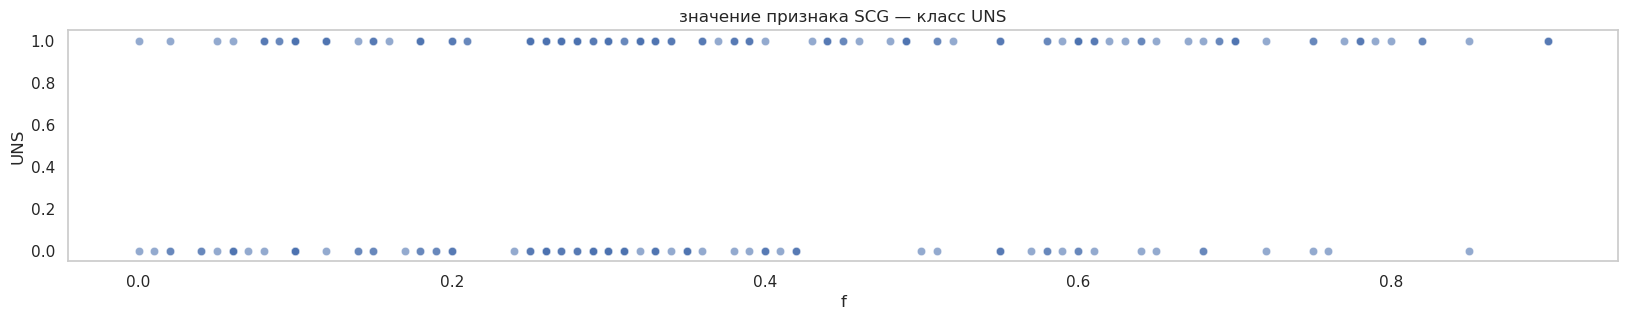

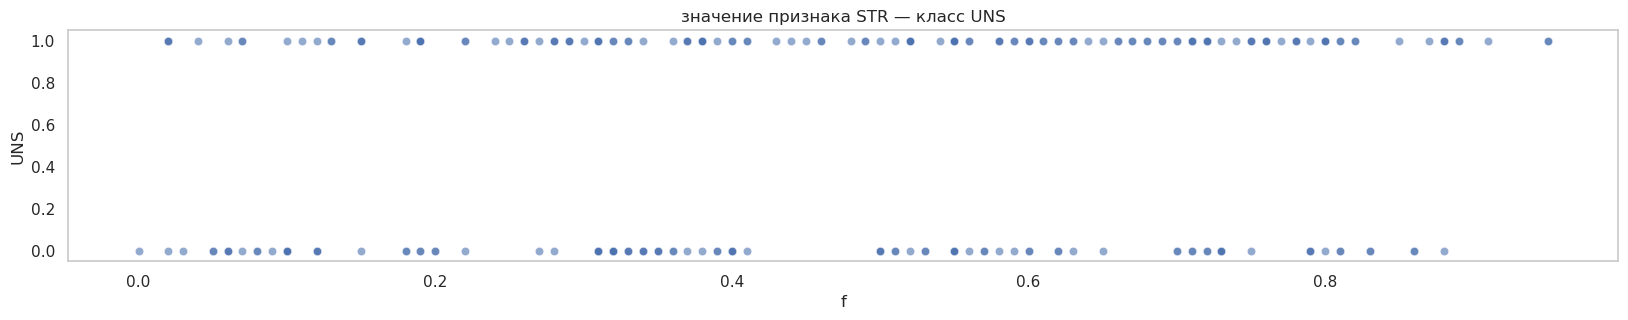

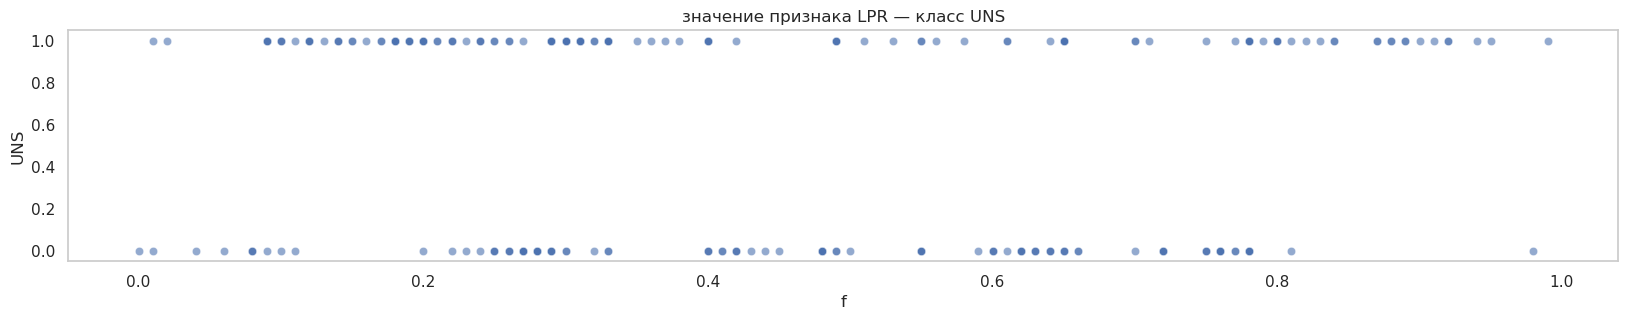

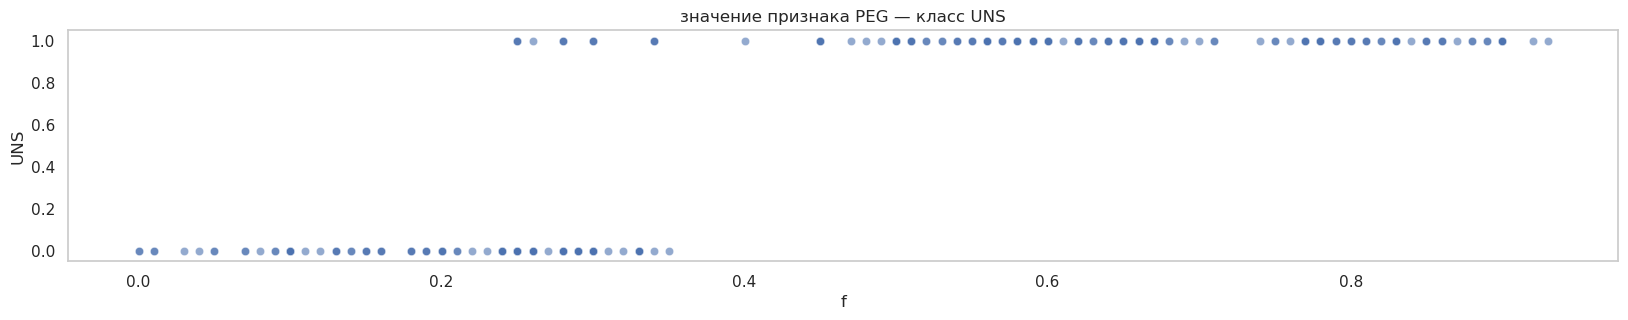

In [218]:
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import seaborn as sns

for f in features:
    feature_vector = df[f]
    target_vector = df['UNS']
    plt.figure(figsize=(20, 3))
    sns.scatterplot(data=df, x=f, y='UNS', sizes=(20, 200), alpha=0.6)
    plt.title(f'значение признака {f} — класс UNS')
    plt.xlabel(f'f')
    plt.ylabel('UNS')
    plt.grid()
    plt.show()

### **Задание 3. (0.6 балла)**

Проанализируйтте построенные кривые. Ответьте на поставленные вопросы:
- По какому признаку нужно производить деление выборки на два поддерева? (0.15 балла)
- Согласуется ли этот результат с визуальной оценкой scatter-графиков? (0.15 балла)
- Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? (0.15 балла)
- Чем отличаются кривые для признаков, по которым деление практически невозможно? (0.15 балла)

**Ответ:**

Деление выборки на два поддерева нужно производить по признаку PEG: threshold_best = 0.33999999999999997, gini_best = -0.08606560274912149.
Результат согласуется с визуальной оценкой scatter-графика, так как при threshold_best = 0.33999999999999997 для PEG объекты разбиваются на два класса очень хорошо (1-ый лист без ошибок, 2-ой лист с 5 ошибками классификации).
Вид кривой для "хороших" признаков - хорошая кривая монотонно возрастает до едиственного максимума, а затем монотонно убывает.
Кривые для признаков, по которым деление практически невозможно отличаются множеством локальных экстремумов и скачков функции, их scatter-графики визуализируют, что большинство значений признака повторяется в различных объектах с различным значением целевой переменной.

### **Задание 4. (1.15 балла)**

В некоторых случаях необходимо анализировать код исполненного класса на предмет оптимальности и ошибок. Потренируйтесь в этом!

- Разберитесь с уже написанным кодом в классе DecisionTree модуля hw4_code_pro.py.
- Найдите ошибки в реализации метода \_fit_node.
- Напишите функцию \_predict_node.

**Примечание 1:**

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в [лекции](https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/lecture-notes/lecture07-trees.pdf) в разделе «Построение дерева».
- Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

**Примечание 2:**

- Выбор лучшего разбиения необходимо производить по критерию Джини.
- Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку, чтобы Джини упал
- Ответ в листе: наиболее часто встречающийся класс в листе.


In [513]:
df.head()

STG   SCG   STR   LPR   PEG  UNS
0  0.00  0.00  0.00  0.00  0.00    0
1  0.08  0.08  0.10  0.24  0.90    1
2  0.06  0.06  0.05  0.25  0.33    0
3  0.10  0.10  0.15  0.65  0.30    1
4  0.08  0.08  0.08  0.98  0.24    0

In [220]:
df.columns

Index(['STG', 'SCG', 'STR', 'LPR', 'PEG', 'UNS'], dtype='object')

In [222]:
feature_types = ['real', 'real', 'real', 'real', 'real']
X = df[['STG', 'SCG', 'STR', 'LPR', 'PEG']]
y = df['UNS']

In [224]:
y = np.array(y)
X = np.array(X)

In [230]:
T = DecisionTree(feature_types)

In [232]:
T.fit(X, y)

In [234]:
T._tree

{'type': 'nonterminal',
 'feature_split': 4,
 'feature_type': 'real',
 'threshold': 0.335,
 'left_child': {'type': 'nonterminal',
  'feature_split': 3,
  'feature_type': 'real',
  'threshold': 0.79,
  'left_child': {'type': 'nonterminal',
   'feature_split': 0,
   'feature_type': 'real',
   'threshold': 0.75,
   'left_child': {'type': 'nonterminal',
    'feature_split': 1,
    'feature_type': 'real',
    'threshold': 0.615,
    'left_child': {'type': 'nonterminal',
     'feature_split': 0,
     'feature_type': 'real',
     'threshold': 0.19,
     'left_child': {'type': 'nonterminal',
      'feature_split': 0,
      'feature_type': 'real',
      'threshold': 0.165,
      'left_child': {'type': 'nonterminal',
       'feature_split': 4,
       'feature_type': 'real',
       'threshold': 0.295,
       'left_child': {'type': 'terminal', 'class': 0},
       'right_child': {'type': 'nonterminal',
        'feature_split': 3,
        'feature_type': 'real',
        'threshold': 0.53,
        'l

In [252]:
import numpy as np
from collections import Counter

class DecisionTree:
    def __init__(self, feature_types, max_depth=None, min_samples_split=None, min_samples_leaf=None):
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        self._tree = {}
        self._feature_types = feature_types
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf

    def _fit_node(self, sub_X, sub_y, node):
        if np.all(sub_y == sub_y[0]):  # заменил '!=' на '==' иначе всегда False
            #print('В листе все объекты одного класса!')
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return
        if sub_X.shape[0] <= 3:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            #print('В листе осталось не более 3 объектов!')
            return
        

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(0, sub_X.shape[1]):   # с 0 начинается индексация
            feature_type = self._feature_types[feature]
            categories_map = {}
            #print(feature, feature_type)
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                counts = Counter(sub_X[:, feature])   # создаёт словарь с ключами - уникальными значениями, значения по ключи - встречаемость
                clicks = Counter(sub_X[sub_y == 1, feature]) # аналогично только для положительного класса
                ratio = {}
                for key, current_count in counts.items():
                    if key in clicks:
                        current_click = clicks[key]
                    else:
                        current_click = 0
                    ratio[key] = current_click / current_count   # на ноль делить не стоит. и нам нужна доля класса '1'. перевернём дробь
                sorted_categories = list(map(lambda x: x[1], sorted(ratio.items(), key=lambda x: x[1])))
                categories_map = dict(zip(sorted_categories, list(range(len(sorted_categories)))))
                feature_vector = np.array(list(map(lambda x: categories_map[ratio[x]], sub_X[:, feature])))  # np.array() не дружит c map(). Добавим list()
            else:
                raise ValueError
            explore_feature = find_best_split(feature_vector, sub_y)
            #print(explore_feature[3], ' before')
            if explore_feature == 'no_gini':
                continue
            #print(explore_feature[3], ' after')

            threshold = explore_feature[2]
            gini = explore_feature[3]
           
            #print(df.columns[feature], feature, feature_vector[:10], threshold, gini)
            #print(gini_best, gini)
            if (gini_best is None) or (gini > gini_best):
                feature_best = feature
                gini_best = gini
                split = feature_vector < threshold

                if feature_type == "real":
                    threshold_best = threshold
                elif feature_type == "categorical":   # зачем здесь иной порог? и не просто порог а список частот?
                    threshold_best = list(map(lambda x: x[0], filter(lambda x: x[1] < threshold, categories_map.items())))
                    left_son = []
                    right_son = []
                    for key, rating in ratio.items():
                        if rating in threshold_best:
                            left_son.append(key)
                        else:
                            right_son.append(key)
                else:
                    raise ValueError

        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["feature_type"] = "real"
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["feature_type"] = "categorical"
            #node["categories_split"] = threshold_best
            node["categories_split"] = left_son # записал сюда сами категории, который пойдут в левого потомка, а остальные в правового при предсказании
        else:
            raise ValueError
        node["left_child"], node["right_child"] = {}, {}

        #print(sub_X[split])
        
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x, node):
        root = self._tree
        while 1:
            if root['type'] == 'terminal':
                precision = root['class']
                break
            else:
                if root['feature_type'] == 'real':
                    if x[root['feature_split']] < root['threshold']:
                        root = root['left_child']
                        continue
                    else:
                        root = root['right_child']
                        continue
                else:
                    if x[root['feature_split']] in root['categories_split']:
                        root = root['left_child']
                        continue
                    else:
                        root = root['right_child']
                        continue
        return precision

    def fit(self, X, y):
        #print("start fitting")
        self._fit_node(X, y, self._tree)

    def predict(self, X):
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
        return np.array(predicted)


### **Задание 5. (0.5 балла)**

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Для этого:

- Скачайте таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/))
- Прочитайте данные с помощью pandas
- Примените к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа.
- Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные)
- Сделайте предсказания для оставшейся половины.
- Вычислите accuracy (так как мы используем эту метрику и в силу задачи, нам не очень важно, что будет классом 1, а что — классом 0).  


У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [236]:
# Ваш код здесь
mushrooms = pd.read_csv('agaricus-lepiota.data', delimiter=",")
mushrooms.head()


p  x  s  n  t p.1  f  c n.1  k  ... s.2  w w.1 p.2 w.2  o p.3 k.1 s.3  u
0  e  x  s  y  t   a  f  c   b  k  ...   s  w   w   p   w  o   p   n   n  g
1  e  b  s  w  t   l  f  c   b  n  ...   s  w   w   p   w  o   p   n   n  m
2  p  x  y  w  t   p  f  c   n  n  ...   s  w   w   p   w  o   p   k   s  u
3  e  x  s  g  f   n  f  w   b  k  ...   s  w   w   p   w  o   e   n   a  g
4  e  x  y  y  t   a  f  c   b  n  ...   s  w   w   p   w  o   p   k   n  g

[5 rows x 23 columns]

In [238]:
columns = mushrooms.columns

In [240]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

for i in columns:
    encoder =  LabelEncoder()
    mushrooms[i] = encoder.fit(mushrooms[i]).transform(mushrooms[i])

mushrooms

p  x  s  n  t  p.1  f  c  n.1   k  ...  s.2  w  w.1  p.2  w.2  o  p.3  \
0     0  5  2  9  1    0  1  0    0   4  ...    2  7    7    0    2  1    4   
1     0  0  2  8  1    3  1  0    0   5  ...    2  7    7    0    2  1    4   
2     1  5  3  8  1    6  1  0    1   5  ...    2  7    7    0    2  1    4   
3     0  5  2  3  0    5  1  1    0   4  ...    2  7    7    0    2  1    0   
4     0  5  3  9  1    0  1  0    0   5  ...    2  7    7    0    2  1    4   
...  .. .. .. .. ..  ... .. ..  ...  ..  ...  ... ..  ...  ...  ... ..  ...   
8118  0  3  2  4  0    5  0  0    0  11  ...    2  5    5    0    1  1    4   
8119  0  5  2  4  0    5  0  0    0  11  ...    2  5    5    0    0  1    4   
8120  0  2  2  4  0    5  0  0    0   5  ...    2  5    5    0    1  1    4   
8121  1  3  3  4  0    8  1  0    1   0  ...    1  7    7    0    2  1    0   
8122  0  5  2  4  0    5  0  0    0  11  ...    2  5    5    0    1  1    4   

      k.1  s.3  u  
0       3    2  1  
1       3    2  3  
2       2    3  5  
3       3    0  1  
4       2    2  1  
...   ...  ... ..  
8118    0    1  2  
8119    0    4  2  
8120    0    1  2  
8121    7    4  2  
8122    4    1  2  

[8123 rows x 23 columns]

In [242]:
y = mushrooms[columns[0]]
X = mushrooms[columns[1:]]
feature_types = ['real' for i in range(X.shape[1])]
y = np.array(y)
X = np.array(X)

In [244]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [273]:
Tree = DecisionTree(feature_types)
Tree.fit(X_train, y_train)

In [274]:
from sklearn.metrics import accuracy_score

y_pred = Tree.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

1.0

In [275]:
Tree._tree

{'depth': 1,
 'type': 'nonterminal',
 'feature_split': 8,
 'feature_type': 'real',
 'threshold': 3.5,
 'left_child': {'depth': 2,
  'type': 'nonterminal',
  'feature_split': 20,
  'feature_type': 'real',
  'threshold': 3.5,
  'left_child': {'depth': 3,
   'type': 'nonterminal',
   'feature_split': 19,
   'feature_type': 'real',
   'threshold': 1.5,
   'left_child': {'depth': 4, 'type': 'terminal', 'class': 1},
   'right_child': {'depth': 4,
    'type': 'nonterminal',
    'feature_split': 7,
    'feature_type': 'real',
    'threshold': 0.5,
    'left_child': {'depth': 5, 'type': 'terminal', 'class': 0},
    'right_child': {'depth': 5, 'type': 'terminal', 'class': 1}}},
  'right_child': {'depth': 3,
   'type': 'nonterminal',
   'feature_split': 10,
   'feature_type': 'real',
   'threshold': 2.0,
   'left_child': {'depth': 4,
    'type': 'nonterminal',
    'feature_split': 12,
    'feature_type': 'real',
    'threshold': 0.5,
    'left_child': {'depth': 5,
     'type': 'nonterminal',
    

### **Задание 6. (бонус, 1 балл)**

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующее задание).

In [115]:
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator


class DecisionTree:
    def __init__(self, feature_types, max_depth=None, min_samples_split=5, min_samples_leaf=None):
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        self._tree = {}
        self._tree['depth'] = 1
        self._feature_types = feature_types
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf

    
    def get_params(self, deep):
        return {
            "feature_types": self._feature_types,
            "max_depth": self._max_depth,
            "min_samples_split": self._min_samples_split,
            "min_samples_leaf": self._min_samples_leaf,
        }


    def set_params(self, **params):
        for param, value in params.items():
            if param == "max_depth":
                self._max_depth = value
            elif param == "min_samples_split":
                self._min_samples_split = value
            elif param == "min_samples_leaf":
                self._min_samples_leaf = value
            else:
                raise ValueError(f"Invalid parameter '{param}'")
        return self

 

    def _fit_node(self, sub_X, sub_y, node):
        if np.all(sub_y == sub_y[0]):  # заменил '!=' на '==' иначе всегда False
            #print('В листе все объекты одного класса!')
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return
        if sub_X.shape[0] < self._min_samples_split:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0] # вернёт список кортежей, первый из которых будет содержать нужный элемент и его количество
            #print(f'В листе осталось менее {self._min_samples_split} объектов!')
            return
        if (self._max_depth is not None) and (node['depth'] == self._max_depth):
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return            


        

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(0, sub_X.shape[1]):   # с 0 начинается индексация
            feature_type = self._feature_types[feature]
            categories_map = {}
            #print(feature, feature_type)
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                counts = Counter(sub_X[:, feature])   # создаёт словарь с ключами - уникальными значениями, значения по ключи - встречаемость
                clicks = Counter(sub_X[sub_y == 1, feature]) # аналогично только для положительного класса
                ratio = {}
                for key, current_count in counts.items():
                    if key in clicks:
                        current_click = clicks[key]
                    else:
                        current_click = 0
                    ratio[key] = current_click / current_count   # на ноль делить не стоит. и нам нужна доля класса '1'. перевернём дробь
                sorted_categories = list(map(lambda x: x[1], sorted(ratio.items(), key=lambda x: x[1])))
                categories_map = dict(zip(sorted_categories, list(range(len(sorted_categories)))))
                feature_vector = np.array(list(map(lambda x: categories_map[ratio[x]], sub_X[:, feature])))  # np.array() не дружит c map(). Добавим list()
            else:
                raise ValueError
            explore_feature = find_best_split(feature_vector, sub_y)
            #print(explore_feature[3], ' before')
            if explore_feature == 'no_gini':
                continue
            #print(explore_feature[3], ' after')

            threshold = explore_feature[2]
            gini = explore_feature[3]
           
            #print(df.columns[feature], feature, feature_vector[:10], threshold, gini)
            #print(gini_best, gini)
            if (gini_best is None) or (gini > gini_best):
                feature_best = feature
                gini_best = gini
                split = feature_vector < threshold

                if feature_type == "real":
                    threshold_best = threshold
                elif feature_type == "categorical":
                    threshold_best = list(map(lambda x: x[0], filter(lambda x: x[1] < threshold, categories_map.items())))
                    left_son = []
                    right_son = []
                    for key, rating in ratio.items():
                        if rating in threshold_best:
                            left_son.append(key)
                        else:
                            right_son.append(key)
                else:
                    raise ValueError

        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0] # получаем кортеж элемента с макс. частотой (класс, частота)
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["feature_type"] = "real"
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["feature_type"] = "categorical"
            #node["categories_split"] = threshold_best
            node["categories_split"] = left_son # записал сюда сами категории, который пойдут в левого потомка, а остальные в правового при предсказании
        else:
            raise ValueError

        if (self._min_samples_leaf is not None) and ((sub_y[split].shape[0] < self._min_samples_leaf) or (sub_y[np.logical_not(split)].shape[0] < self._min_samples_leaf)):
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return
        
        
        node["left_child"], node["right_child"] = {}, {}
        node["left_child"]['depth'] = node['depth']+1
        node["right_child"]['depth'] = node['depth']+1

        
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x, node):
        root = self._tree
        while 1:
            if root['type'] == 'terminal':                 
                precision = root['class']
                break
            else:
                if root['feature_type'] == 'real':
                    if x[root['feature_split']] < root['threshold']:
                        root = root['left_child']
                        continue
                    else:
                        root = root['right_child']
                        continue
                else:
                    if x[root['feature_split']] in root['categories_split']:
                        root = root['left_child']
                        continue
                    else:
                        root = root['right_child']
                        continue
        return precision

    def fit(self, X, y):
        #print("start fitting")
        self._fit_node(X, y, self._tree)

    def predict(self, X):
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
        return predicted


#### Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующее задание).

In [449]:
tic_tac_toe = pd.read_csv('tic-tac-toe.data', delimiter=",")

In [451]:
tic_tac_toe.head()

x x.1 x.2 x.3  o o.1 x.4 o.2 o.3  positive
0  x   x   x   x  o   o   o   x   o  positive
1  x   x   x   x  o   o   o   o   x  positive
2  x   x   x   x  o   o   o   b   b  positive
3  x   x   x   x  o   o   b   o   b  positive
4  x   x   x   x  o   o   b   b   o  positive

In [453]:
tic_tac_toe.shape

(957, 10)

In [455]:
tic_tac_toe.describe()

x  x.1  x.2  x.3    o  o.1  x.4  o.2  o.3  positive
count   957  957  957  957  957  957  957  957  957       957
unique    3    3    3    3    3    3    3    3    3         2
top       x    x    x    x    x    x    x    x    x  positive
freq    417  377  417  377  458  378  417  378  418       625

In [457]:
tic_tac_toe['positive'].value_counts()

positive
positive    625
negative    332
Name: count, dtype: int64

In [459]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

columns = tic_tac_toe.columns
for i in columns:
    encoder =  LabelEncoder()
    tic_tac_toe[i] = encoder.fit(tic_tac_toe[i]).transform(tic_tac_toe[i])

tic_tac_toe.head()

x  x.1  x.2  x.3  o  o.1  x.4  o.2  o.3  positive
0  2    2    2    2  1    1    1    2    1         1
1  2    2    2    2  1    1    1    1    2         1
2  2    2    2    2  1    1    1    0    0         1
3  2    2    2    2  1    1    0    1    0         1
4  2    2    2    2  1    1    0    0    1         1

In [461]:
tic_tac_toe['positive'].value_counts()

positive
1    625
0    332
Name: count, dtype: int64

In [463]:
y_t = tic_tac_toe['positive']
X_t = tic_tac_toe[columns[0:-1]]
y_t = np.array(y_t)
X_t = np.array(X_t)
feature_types = ['real' for i in range(X_t.shape[1])]

**max_depth**

In [ ]:
from sklearn.model_selection import cross_val_score
from  sklearn.metrics import make_scorer, accuracy_score

max_depth = [i for i in range(1, 120)]
score = []

for i in max_depth:
    model = DecisionTree(feature_types, max_depth = i)
    s = cross_val_score(model, X_t, y_t, cv=10, scoring=make_scorer(accuracy_score)).mean()
    score.append(s)

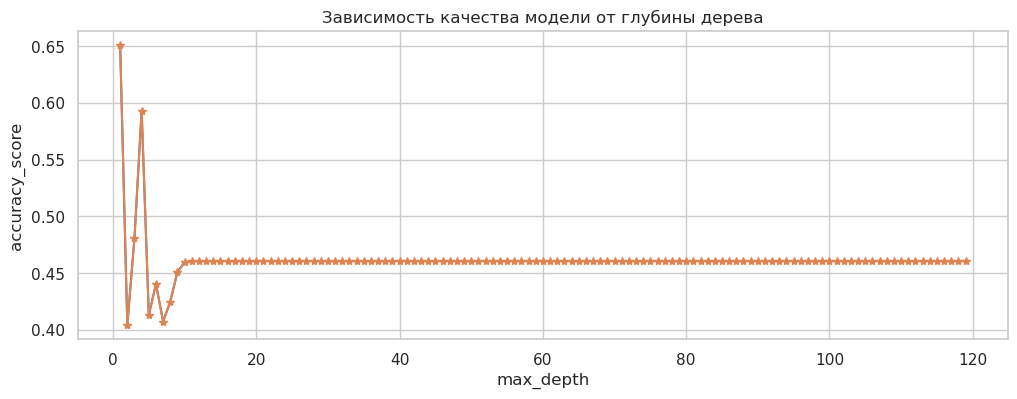

In [490]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(max_depth, score)
plt.plot(max_depth, score, marker = '*')
plt.xlabel('max_depth')
plt.ylabel('accuracy_score')
plt.title('Зависимость качества модели от глубины дерева')
plt.grid(True)

fig.set_size_inches(12, 4)

plt.show()

**min_samples_split**

In [492]:
from sklearn.model_selection import cross_val_score
from  sklearn.metrics import make_scorer, accuracy_score

min_samples_split = [i for i in range(3, 51)]
score = []

for i in min_samples_split:
    model = DecisionTree(feature_types, min_samples_split = i)
    s = cross_val_score(model, X_t, y_t, cv=10, scoring=make_scorer(accuracy_score)).mean()
    score.append(s)

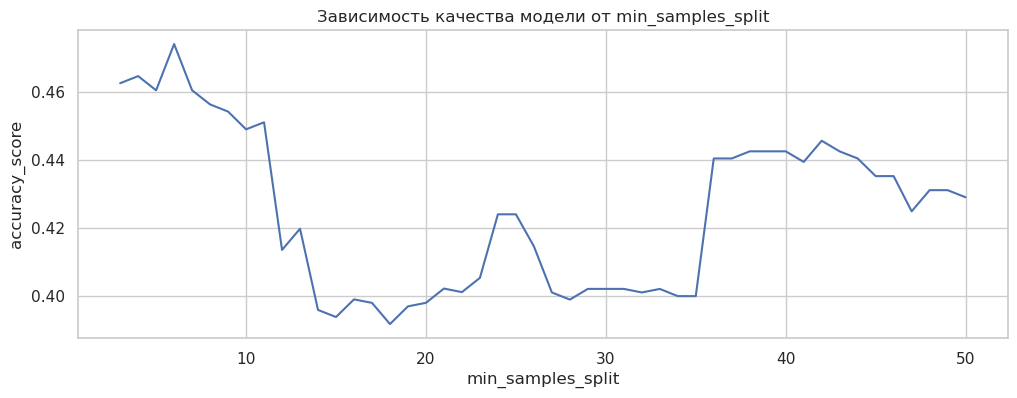

In [494]:
import matplotlib.pyplot as plt

fig = plt.figure()

plt.plot(min_samples_split, score)

plt.xlabel('min_samples_split')
plt.ylabel('accuracy_score')
plt.title('Зависимость качества модели от min_samples_split')
plt.grid(True)

fig.set_size_inches(12, 4)
plt.show()

**min_samples_leaf**

In [506]:
from sklearn.model_selection import cross_val_score
from  sklearn.metrics import make_scorer, accuracy_score

min_samples_leaf = [i for i in range(1, 51)]
score = []

for i in min_samples_leaf:
    model = DecisionTree(feature_types, min_samples_leaf = i)
    s = cross_val_score(model, X_t, y_t, cv=3, scoring=make_scorer(accuracy_score)).mean()
    score.append(s)

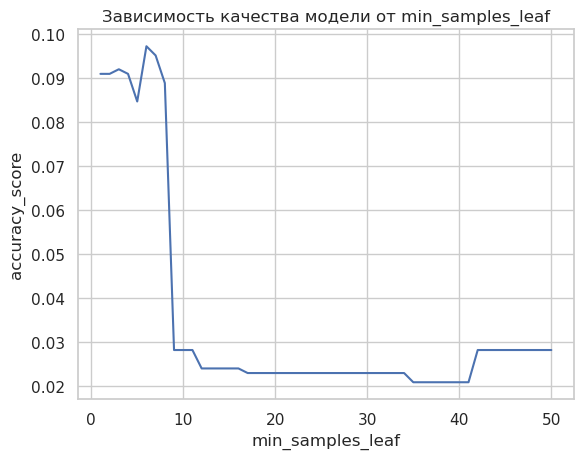

In [508]:
import matplotlib.pyplot as plt
#fig = plt.figure()

plt.plot(min_samples_leaf, score)

plt.xlabel('min_samples_leaf')
plt.ylabel('accuracy_score')
plt.title('Зависимость качества модели от min_samples_leaf')
plt.grid(True)
#fig.set_size_inches(12, 4)
plt.show()

### **Задание 7. (2 балла)**

**1. Загрузите следующие наборы данных** (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (они записаны в Data Folder, в файле *.names):
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

**2. Закодируйте категориальные признаки, использовав LabelEncoder.** С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

**Рекомендации:**
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами.

In [280]:
from sklearn.model_selection import cross_val_score
from  sklearn.metrics import make_scorer, accuracy_score


In [282]:
answer = pd.DataFrame(index = ['mushrooms', 'tic-tac-toe', 'cars', 'nursery'], columns=['DecisionTree real', 'DecisionTree cat', 'DecisionTree real+OHE', 'DecisionTreeClassifier '])



In [284]:
# Ваш код здесь
mushrooms = pd.read_csv('agaricus-lepiota.data', delimiter=",")
tic_tac_toe = pd.read_csv('tic-tac-toe.data', delimiter=",")
cars = pd.read_csv('car.data', delimiter=",")
nursery = pd.read_csv('nursery.data', delimiter=",")

#### mushrooms (классы записаны в нулевом столбце)

In [287]:
mushrooms.shape

(8123, 23)

In [289]:
mushrooms.describe()

p     x     s     n     t   p.1     f     c   n.1     k  ...   s.2  \
count   8123  8123  8123  8123  8123  8123  8123  8123  8123  8123  ...  8123   
unique     2     6     4    10     2     9     2     2     2    12  ...     4   
top        e     x     y     n     f     n     f     c     b     b  ...     s   
freq    4208  3655  3244  2283  4748  3528  7913  6811  5612  1728  ...  4935   

           w   w.1   p.2   w.2     o   p.3   k.1   s.3     u  
count   8123  8123  8123  8123  8123  8123  8123  8123  8123  
unique     9     9     1     4     3     5     9     6     7  
top        w     w     p     w     o     p     w     v     d  
freq    4463  4383  8123  7923  7487  3967  2388  4040  3148  

[4 rows x 23 columns]

In [291]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

columns = mushrooms.columns
for i in columns:
    encoder =  LabelEncoder()
    mushrooms[i] = encoder.fit(mushrooms[i]).transform(mushrooms[i])
mushrooms

p  x  s  n  t  p.1  f  c  n.1   k  ...  s.2  w  w.1  p.2  w.2  o  p.3  \
0     0  5  2  9  1    0  1  0    0   4  ...    2  7    7    0    2  1    4   
1     0  0  2  8  1    3  1  0    0   5  ...    2  7    7    0    2  1    4   
2     1  5  3  8  1    6  1  0    1   5  ...    2  7    7    0    2  1    4   
3     0  5  2  3  0    5  1  1    0   4  ...    2  7    7    0    2  1    0   
4     0  5  3  9  1    0  1  0    0   5  ...    2  7    7    0    2  1    4   
...  .. .. .. .. ..  ... .. ..  ...  ..  ...  ... ..  ...  ...  ... ..  ...   
8118  0  3  2  4  0    5  0  0    0  11  ...    2  5    5    0    1  1    4   
8119  0  5  2  4  0    5  0  0    0  11  ...    2  5    5    0    0  1    4   
8120  0  2  2  4  0    5  0  0    0   5  ...    2  5    5    0    1  1    4   
8121  1  3  3  4  0    8  1  0    1   0  ...    1  7    7    0    2  1    0   
8122  0  5  2  4  0    5  0  0    0  11  ...    2  5    5    0    1  1    4   

      k.1  s.3  u  
0       3    2  1  
1       3    2  3  
2       2    3  5  
3       3    0  1  
4       2    2  1  
...   ...  ... ..  
8118    0    1  2  
8119    0    4  2  
8120    0    1  2  
8121    7    4  2  
8122    4    1  2  

[8123 rows x 23 columns]

In [293]:
y_m = mushrooms[columns[0]]
X_m = mushrooms[columns[1:]]
y_m = np.array(y_m)
X_m = np.array(X_m)

In [295]:
X_m.shape

(8123, 22)

In [305]:
from sklearn.model_selection import cross_val_score
from  sklearn.metrics import make_scorer, accuracy_score
m_answer = []

feature_types = ['real' for i in range(X_m.shape[1])]

model = DecisionTree(feature_types)

In [307]:
first_m = cross_val_score(model, X_m, y_m, cv=10, scoring=make_scorer(accuracy_score), verbose=2).mean()
first_m

[CV] END .................................................... total time= 8.6min
[CV] END .................................................... total time=10.2min
[CV] END .................................................... total time=10.8min
[CV] END .................................................... total time=10.5min
[CV] END .................................................... total time=12.1min
[CV] END .................................................... total time=10.4min
[CV] END .................................................... total time=11.3min
[CV] END .................................................... total time=11.4min
[CV] END .................................................... total time= 7.5min
[CV] END .................................................... total time=10.0min


0.9992610837438424

In [309]:
m_answer.append(first_m)

In [311]:
m_answer

[0.9992610837438424]

In [313]:
from sklearn.model_selection import cross_val_score
from  sklearn.metrics import make_scorer, accuracy_score

feature_types = ['categorical' for i in range(X_m.shape[1])]

model = DecisionTree(feature_types)

In [315]:
second_m = cross_val_score(model, X_m, y_m, cv=10, scoring=make_scorer(accuracy_score), verbose=3).mean()
m_answer.append(second_m)
second_m

[CV] END ................................ score: (test=1.000) total time=10.1min
[CV] END ................................ score: (test=1.000) total time= 9.4min
[CV] END ................................ score: (test=1.000) total time= 9.4min
[CV] END ................................ score: (test=1.000) total time= 9.8min
[CV] END ................................ score: (test=1.000) total time=10.6min
[CV] END ................................ score: (test=1.000) total time=11.8min
[CV] END ................................ score: (test=1.000) total time=10.3min
[CV] END ................................ score: (test=1.000) total time=12.2min
[CV] END ................................ score: (test=1.000) total time=11.6min
[CV] END ................................ score: (test=1.000) total time=10.7min


1.0

In [ ]:
#указывайте параметр sparse_output=False в OneHotEncoder

In [317]:
mushrooms = pd.read_csv('agaricus-lepiota.data', delimiter=",")
y_m_OHE = mushrooms[columns[0]]
X_m_OHE = mushrooms[columns[1:]]
y_m_OHE = np.array(y_m)

In [319]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)

encoded_data = encoder.fit_transform(X_m_OHE)


encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out())

X_m_OHE = np.array(encoded_df)
#print(encoded_df)

In [321]:
from sklearn.model_selection import cross_val_score
from  sklearn.metrics import make_scorer, accuracy_score

feature_types = ['real' for i in range(X_m_OHE.shape[1])]

model = DecisionTree(feature_types)

In [323]:
third_m = cross_val_score(model, X_m_OHE, y_m_OHE, cv=10, scoring=make_scorer(accuracy_score), verbose=3).mean()

[CV] END ................................ score: (test=1.000) total time=39.6min
[CV] END ................................ score: (test=1.000) total time=45.1min
[CV] END ................................ score: (test=1.000) total time=47.3min
[CV] END ................................ score: (test=1.000) total time=40.2min
[CV] END ................................ score: (test=1.000) total time=40.1min
[CV] END ................................ score: (test=1.000) total time=41.6min
[CV] END ................................ score: (test=0.996) total time=39.0min
[CV] END ................................ score: (test=1.000) total time=36.1min
[CV] END ................................ score: (test=1.000) total time=44.9min
[CV] END ................................ score: (test=1.000) total time=44.1min


In [325]:
m_answer.append(third_m)
third_m

0.9996305418719211

In [327]:
m_answer

[0.9992610837438424, 1.0, 0.9996305418719211]

In [329]:
# DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from  sklearn.metrics import make_scorer, accuracy_score

model = DecisionTreeClassifier()

In [331]:
fourth_m = cross_val_score(model, X_m, y_m, cv=10, scoring=make_scorer(accuracy_score), verbose=3).mean()

[CV] END ................................ score: (test=0.686) total time=   0.0s
[CV] END ................................ score: (test=1.000) total time=   0.0s
[CV] END ................................ score: (test=1.000) total time=   0.0s
[CV] END ................................ score: (test=1.000) total time=   0.0s
[CV] END ................................ score: (test=1.000) total time=   0.0s
[CV] END ................................ score: (test=1.000) total time=   0.0s
[CV] END ................................ score: (test=1.000) total time=   0.0s
[CV] END ................................ score: (test=1.000) total time=   0.0s
[CV] END ................................ score: (test=0.985) total time=   0.0s
[CV] END ................................ score: (test=1.000) total time=   0.0s


In [333]:
m_answer.append(fourth_m)
fourth_m

0.9671568538345483

In [335]:
m_answer

[0.9992610837438424, 1.0, 0.9996305418719211, 0.9671568538345483]

In [337]:
answer.iloc[0] = m_answer

In [339]:
answer

DecisionTree real DecisionTree cat DecisionTree real+OHE  \
mushrooms            0.999261              1.0              0.999631   
tic-tac-toe               NaN              NaN                   NaN   
cars                      NaN              NaN                   NaN   
nursery                   NaN              NaN                   NaN   

            DecisionTreeClassifier   
mushrooms                  0.967157  
tic-tac-toe                     NaN  
cars                            NaN  
nursery                         NaN

#### tic-tac-toe (классы записаны в последнем столбце)

In [342]:
tic_tac_toe.head()

x x.1 x.2 x.3  o o.1 x.4 o.2 o.3  positive
0  x   x   x   x  o   o   o   x   o  positive
1  x   x   x   x  o   o   o   o   x  positive
2  x   x   x   x  o   o   o   b   b  positive
3  x   x   x   x  o   o   b   o   b  positive
4  x   x   x   x  o   o   b   b   o  positive

In [344]:
tic_tac_toe.shape

(957, 10)

In [346]:
tic_tac_toe.describe()

x  x.1  x.2  x.3    o  o.1  x.4  o.2  o.3  positive
count   957  957  957  957  957  957  957  957  957       957
unique    3    3    3    3    3    3    3    3    3         2
top       x    x    x    x    x    x    x    x    x  positive
freq    417  377  417  377  458  378  417  378  418       625

In [348]:
tic_tac_toe['positive'].value_counts()

positive
positive    625
negative    332
Name: count, dtype: int64

In [350]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

columns = tic_tac_toe.columns
for i in columns:
    encoder =  LabelEncoder()
    tic_tac_toe[i] = encoder.fit(tic_tac_toe[i]).transform(tic_tac_toe[i])

tic_tac_toe.head()

x  x.1  x.2  x.3  o  o.1  x.4  o.2  o.3  positive
0  2    2    2    2  1    1    1    2    1         1
1  2    2    2    2  1    1    1    1    2         1
2  2    2    2    2  1    1    1    0    0         1
3  2    2    2    2  1    1    0    1    0         1
4  2    2    2    2  1    1    0    0    1         1

In [352]:
tic_tac_toe['positive'].value_counts()

positive
1    625
0    332
Name: count, dtype: int64

In [354]:
y_t = tic_tac_toe['positive']
X_t = tic_tac_toe[columns[0:-1]]
y_t = np.array(y_t)
X_t = np.array(X_t)

In [356]:
X_t.shape

(957, 9)

In [358]:
from sklearn.model_selection import cross_val_score
from  sklearn.metrics import make_scorer, accuracy_score
t_answer = []

feature_types = ['real' for i in range(X_t.shape[1])]

model = DecisionTree(feature_types)

first_t = cross_val_score(model, X_t, y_t, cv=10, scoring=make_scorer(accuracy_score)).mean()
print(first_t)

t_answer.append(first_t)

0.46054824561403507


In [359]:
from sklearn.model_selection import cross_val_score
from  sklearn.metrics import make_scorer, accuracy_score

feature_types = ['categorical' for i in range(X_t.shape[1])]

model = DecisionTree(feature_types)

second_t = cross_val_score(model, X_t, y_t, cv=10, scoring=make_scorer(accuracy_score), verbose=3).mean()
t_answer.append(second_t)
second_t

[CV] END ................................ score: (test=0.552) total time=   3.2s
[CV] END ................................ score: (test=0.573) total time=   4.9s
[CV] END ................................ score: (test=0.979) total time=   4.6s
[CV] END ................................ score: (test=0.240) total time=   3.4s
[CV] END ................................ score: (test=0.469) total time=   5.4s
[CV] END ................................ score: (test=0.854) total time=   3.4s
[CV] END ................................ score: (test=0.583) total time=   3.6s
[CV] END ................................ score: (test=0.484) total time=   3.3s
[CV] END ................................ score: (test=0.600) total time=   3.3s
[CV] END ................................ score: (test=0.211) total time=   3.4s


0.5544736842105262

In [362]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from  sklearn.metrics import make_scorer, accuracy_score

tic_tac_toe = pd.read_csv('tic-tac-toe.data', delimiter=",")


y_t_OHE = y_t # выще разбили на 0 и 1
X_t_OHE = tic_tac_toe[columns[0:-1]]
y_t_OHE = np.array(y_t_OHE)
X_t_OHE = np.array(X_t_OHE)





encoder = OneHotEncoder(sparse_output=False)

encoded_data = encoder.fit_transform(X_t_OHE)


encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out())

X_t_OHE = np.array(encoded_df)


feature_types = ['real' for i in range(X_t_OHE.shape[1])]

model = DecisionTree(feature_types)

third_t = cross_val_score(model, X_t_OHE, y_t_OHE, cv=10, scoring=make_scorer(accuracy_score), verbose=3).mean()

t_answer.append(third_t)
third_t

[CV] END ................................ score: (test=0.521) total time=   7.8s
[CV] END ................................ score: (test=0.562) total time=   7.9s
[CV] END ................................ score: (test=0.979) total time=   9.3s
[CV] END ................................ score: (test=0.240) total time=   8.1s
[CV] END ................................ score: (test=0.458) total time=   8.2s
[CV] END ................................ score: (test=0.854) total time=   8.3s
[CV] END ................................ score: (test=0.583) total time=   8.3s
[CV] END ................................ score: (test=0.589) total time=   8.3s
[CV] END ................................ score: (test=0.632) total time=   9.2s
[CV] END ................................ score: (test=0.211) total time=  12.7s


0.5629495614035087

In [364]:
# DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from  sklearn.metrics import make_scorer, accuracy_score

model = DecisionTreeClassifier()

fourth_t = cross_val_score(model, X_t, y_t, cv=10, scoring=make_scorer(accuracy_score), verbose=3).mean()

t_answer.append(fourth_t)
fourth_t

[CV] END ................................ score: (test=0.417) total time=   0.0s
[CV] END ................................ score: (test=0.719) total time=   0.0s
[CV] END ................................ score: (test=0.521) total time=   0.0s
[CV] END ................................ score: (test=0.875) total time=   0.0s
[CV] END ................................ score: (test=0.771) total time=   0.0s
[CV] END ................................ score: (test=0.688) total time=   0.0s
[CV] END ................................ score: (test=0.812) total time=   0.0s
[CV] END ................................ score: (test=0.863) total time=   0.0s
[CV] END ................................ score: (test=0.926) total time=   0.0s
[CV] END ................................ score: (test=0.905) total time=   0.0s


0.7496820175438598

In [366]:
t_answer

[0.46054824561403507,
 0.5544736842105262,
 0.5629495614035087,
 0.7496820175438598]

In [368]:
answer.iloc[1] = t_answer
answer

DecisionTree real DecisionTree cat DecisionTree real+OHE  \
mushrooms            0.999261              1.0              0.999631   
tic-tac-toe          0.460548         0.554474               0.56295   
cars                      NaN              NaN                   NaN   
nursery                   NaN              NaN                   NaN   

            DecisionTreeClassifier   
mushrooms                  0.967157  
tic-tac-toe                0.749682  
cars                            NaN  
nursery                         NaN

#### cars  (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)

In [372]:
cars.head()

vhigh vhigh.1  2 2.1  small   low  unacc
0  vhigh   vhigh  2   2  small   med  unacc
1  vhigh   vhigh  2   2  small  high  unacc
2  vhigh   vhigh  2   2    med   low  unacc
3  vhigh   vhigh  2   2    med   med  unacc
4  vhigh   vhigh  2   2    med  high  unacc

In [374]:
cars.shape

(1727, 7)

In [376]:
cars.describe()

vhigh vhigh.1     2   2.1 small   low  unacc
count   1727    1727  1727  1727  1727  1727   1727
unique     4       4     4     3     3     3      4
top     high    high     3     4   med   med  unacc
freq     432     432   432   576   576   576   1209

In [378]:
cars['unacc'].value_counts()

unacc
unacc    1209
acc       384
good       69
vgood      65
Name: count, dtype: int64

In [380]:
cars['unacc'] = cars['unacc'].apply(lambda x: 0 if x in ['unacc', 'acc'] else 1)

In [382]:
cars['unacc'].value_counts()

unacc
0    1593
1     134
Name: count, dtype: int64

In [384]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

columns = cars.columns
for i in columns[0:-1]:
    encoder =  LabelEncoder()
    cars[i] = encoder.fit(cars[i]).transform(cars[i])

cars.head()

vhigh  vhigh.1  2  2.1  small  low  unacc
0      3        3  0    0      2    2      0
1      3        3  0    0      2    0      0
2      3        3  0    0      1    1      0
3      3        3  0    0      1    2      0
4      3        3  0    0      1    0      0

In [386]:
y_c = cars['unacc']
X_c = cars[columns[0:-1]]
y_c = np.array(y_c)
X_c = np.array(X_c)

In [388]:
X_c.shape

(1727, 6)

In [390]:
from sklearn.model_selection import cross_val_score
from  sklearn.metrics import make_scorer, accuracy_score
c_answer = []

feature_types = ['real' for i in range(X_c.shape[1])]

model = DecisionTree(feature_types)

first_c = cross_val_score(model, X_c, y_c, cv=10, scoring=make_scorer(accuracy_score)).mean()
print(first_c)

c_answer.append(first_c)

0.9437626025003361


In [391]:
from sklearn.model_selection import cross_val_score
from  sklearn.metrics import make_scorer, accuracy_score

feature_types = ['categorical' for i in range(X_c.shape[1])]

model = DecisionTree(feature_types)

second_c = cross_val_score(model, X_c, y_c, cv=10, scoring=make_scorer(accuracy_score), verbose=3).mean()
c_answer.append(second_c)
second_c

[CV] END ................................ score: (test=1.000) total time=   5.0s
[CV] END ................................ score: (test=1.000) total time=   7.1s
[CV] END ................................ score: (test=1.000) total time=   6.1s
[CV] END ................................ score: (test=1.000) total time=   5.0s
[CV] END ................................ score: (test=1.000) total time=   5.1s
[CV] END ................................ score: (test=1.000) total time=   6.4s
[CV] END ................................ score: (test=0.855) total time=   6.0s
[CV] END ................................ score: (test=0.930) total time=   5.5s
[CV] END ................................ score: (test=0.878) total time=   3.9s
[CV] END ................................ score: (test=0.959) total time=   4.5s


0.9622933189944884

In [394]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from  sklearn.metrics import make_scorer, accuracy_score

cars = pd.read_csv('car.data', delimiter=",")


y_c_OHE = y_c
X_c_OHE = cars[columns[0:-1]]
y_c_OHE = np.array(y_c_OHE)
X_c_OHE = np.array(X_c_OHE)




encoder = OneHotEncoder(sparse_output=False)

encoded_data = encoder.fit_transform(X_c_OHE)


encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out())

X_c_OHE = np.array(encoded_df)


feature_types = ['real' for i in range(X_c_OHE.shape[1])]

model = DecisionTree(feature_types)

third_c = cross_val_score(model, X_c_OHE, y_c_OHE, cv=10, scoring=make_scorer(accuracy_score), verbose=3).mean()

c_answer.append(third_c)
third_c

[CV] END ................................ score: (test=1.000) total time=  17.7s
[CV] END ................................ score: (test=1.000) total time=  15.6s
[CV] END ................................ score: (test=0.942) total time=  16.5s
[CV] END ................................ score: (test=1.000) total time=  17.8s
[CV] END ................................ score: (test=0.792) total time=  18.4s
[CV] END ................................ score: (test=0.931) total time=  19.3s
[CV] END ................................ score: (test=0.908) total time=  14.3s
[CV] END ................................ score: (test=0.872) total time=  15.8s
[CV] END ................................ score: (test=0.855) total time=  15.7s
[CV] END ................................ score: (test=0.878) total time=  16.9s


0.9176905498050812

In [396]:
# DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from  sklearn.metrics import make_scorer, accuracy_score

model = DecisionTreeClassifier()

fourth_c = cross_val_score(model, X_c, y_c, cv=10, scoring=make_scorer(accuracy_score), verbose=3).mean()

c_answer.append(fourth_c)
fourth_c

[CV] END ................................ score: (test=0.925) total time=   0.0s
[CV] END ................................ score: (test=0.960) total time=   0.0s
[CV] END ................................ score: (test=0.925) total time=   0.0s
[CV] END ................................ score: (test=0.994) total time=   0.0s
[CV] END ................................ score: (test=0.971) total time=   0.0s
[CV] END ................................ score: (test=0.988) total time=   0.0s
[CV] END ................................ score: (test=0.919) total time=   0.0s
[CV] END ................................ score: (test=0.884) total time=   0.0s
[CV] END ................................ score: (test=0.930) total time=   0.0s
[CV] END ................................ score: (test=0.953) total time=   0.0s


0.9449522785320607

In [398]:
answer.iloc[2] = c_answer
answer

DecisionTree real DecisionTree cat DecisionTree real+OHE  \
mushrooms            0.999261              1.0              0.999631   
tic-tac-toe          0.460548         0.554474               0.56295   
cars                 0.943763         0.962293              0.917691   
nursery                   NaN              NaN                   NaN   

            DecisionTreeClassifier   
mushrooms                  0.967157  
tic-tac-toe                0.749682  
cars                       0.944952  
nursery                         NaN

#### nursery (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1)

In [400]:
nursery.head()

usual  proper  complete  1  convenient convenient.1        nonprob  \
0  usual  proper  complete  1  convenient   convenient        nonprob   
1  usual  proper  complete  1  convenient   convenient        nonprob   
2  usual  proper  complete  1  convenient   convenient  slightly_prob   
3  usual  proper  complete  1  convenient   convenient  slightly_prob   
4  usual  proper  complete  1  convenient   convenient  slightly_prob   

   recommended  recommend  
0     priority   priority  
1    not_recom  not_recom  
2  recommended  recommend  
3     priority   priority  
4    not_recom  not_recom

In [402]:
nursery.shape

(12959, 9)

In [404]:
nursery.describe()

usual       proper   complete      1 convenient convenient.1  \
count         12959        12959      12959  12959      12959        12959   
unique            3            5          4      4          3            2   
top     pretentious  less_proper  completed      2  less_conv       inconv   
freq           4320         2592       3240   3240       4320         6480   

              nonprob recommended  recommend  
count           12959       12959      12959  
unique              3           3          5  
top     slightly_prob    priority  not_recom  
freq             4320        4320       4320

In [406]:
nursery['recommend'].value_counts()

recommend
not_recom     4320
priority      4266
spec_prior    4044
very_recom     328
recommend        1
Name: count, dtype: int64

In [408]:
# not_recom и recommend — класс 0
nursery['recommend'] = nursery['recommend'].apply(lambda x: 0 if x in ['not_recom', 'recommend'] else 1)

In [410]:
nursery['recommend'].value_counts()

recommend
1    8638
0    4321
Name: count, dtype: int64

In [412]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

columns = nursery.columns
for i in columns[0:-1]:
    encoder =  LabelEncoder()
    nursery[i] = encoder.fit(nursery[i]).transform(nursery[i])

nursery.head()

usual  proper  complete  1  convenient  convenient.1  nonprob  recommended  \
0      2       3         0  0           0             0        0            1   
1      2       3         0  0           0             0        0            0   
2      2       3         0  0           0             0        2            2   
3      2       3         0  0           0             0        2            1   
4      2       3         0  0           0             0        2            0   

   recommend  
0          1  
1          0  
2          0  
3          1  
4          0

In [414]:
y_n = nursery['recommend']
X_n = nursery[columns[0:-1]]
y_n = np.array(y_n)
X_n = np.array(X_n)

In [416]:
X_n.shape

(12959, 8)

In [418]:
from sklearn.model_selection import cross_val_score
from  sklearn.metrics import make_scorer, accuracy_score
n_answer = []

feature_types = ['real' for i in range(X_n.shape[1])]

model = DecisionTree(feature_types)

first_n = cross_val_score(model, X_n, y_n, cv=10, scoring=make_scorer(accuracy_score), verbose=3).mean()
print(first_n)

n_answer.append(first_n)

[CV] END ................................ score: (test=0.999) total time= 3.7min
[CV] END ................................ score: (test=1.000) total time= 5.4min
[CV] END ................................ score: (test=1.000) total time= 5.4min
[CV] END ................................ score: (test=1.000) total time= 5.7min
[CV] END ................................ score: (test=1.000) total time= 5.9min
[CV] END ................................ score: (test=1.000) total time= 5.8min
[CV] END ................................ score: (test=1.000) total time= 6.1min
[CV] END ................................ score: (test=1.000) total time= 5.9min
[CV] END ................................ score: (test=1.000) total time= 5.9min
[CV] END ................................ score: (test=1.000) total time= 5.8min
0.9999228395061728


In [421]:
from sklearn.model_selection import cross_val_score
from  sklearn.metrics import make_scorer, accuracy_score

feature_types = ['categorical' for i in range(X_n.shape[1])]

model = DecisionTree(feature_types)

second_n = cross_val_score(model, X_n, y_n, cv=10, scoring=make_scorer(accuracy_score), verbose=3).mean()
n_answer.append(second_n)
second_n

[CV] END ................................ score: (test=0.999) total time= 3.9min
[CV] END ................................ score: (test=1.000) total time= 5.6min
[CV] END ................................ score: (test=1.000) total time= 6.0min
[CV] END ................................ score: (test=1.000) total time= 5.7min
[CV] END ................................ score: (test=1.000) total time= 6.0min
[CV] END ................................ score: (test=1.000) total time= 6.4min
[CV] END ................................ score: (test=1.000) total time= 6.0min
[CV] END ................................ score: (test=1.000) total time= 6.0min
[CV] END ................................ score: (test=1.000) total time= 5.8min
[CV] END ................................ score: (test=1.000) total time= 6.2min


0.9999228395061728

In [427]:
n_answer

[0.9999228395061728, 0.9999228395061728]

In [429]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from  sklearn.metrics import make_scorer, accuracy_score

nursery = pd.read_csv('nursery.data', delimiter=",")

y_n_OHE = y_n # выше разбили на 2 класса по заданию
X_n_OHE = nursery[columns[0:-1]]
y_n_OHE = np.array(y_n)
X_n_OHE = np.array(X_n)


encoder = OneHotEncoder(sparse_output=False)

encoded_data = encoder.fit_transform(X_n_OHE)


encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out())

X_n_OHE = np.array(encoded_df)


feature_types = ['real' for i in range(X_n_OHE.shape[1])]

model = DecisionTree(feature_types)

third_n = cross_val_score(model, X_n_OHE, y_n_OHE, cv=10, scoring=make_scorer(accuracy_score), verbose=3).mean()

n_answer.append(third_n)
third_n

[CV] END ................................ score: (test=0.999) total time=11.2min
[CV] END ................................ score: (test=1.000) total time=16.8min
[CV] END ................................ score: (test=1.000) total time=16.8min
[CV] END ................................ score: (test=1.000) total time=15.6min
[CV] END ................................ score: (test=1.000) total time=15.4min
[CV] END ................................ score: (test=1.000) total time=16.2min
[CV] END ................................ score: (test=1.000) total time=16.4min
[CV] END ................................ score: (test=1.000) total time=15.9min
[CV] END ................................ score: (test=1.000) total time=17.3min
[CV] END ................................ score: (test=1.000) total time=16.6min


0.9999228395061728

In [441]:
# DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from  sklearn.metrics import make_scorer, accuracy_score

model = DecisionTreeClassifier()

fourth_n = cross_val_score(model, X_n, y_n, cv=10, scoring=make_scorer(accuracy_score), verbose=3).mean()

n_answer.append(fourth_n)
fourth_n

[CV] END ................................ score: (test=0.999) total time=   0.0s
[CV] END ................................ score: (test=1.000) total time=   0.0s
[CV] END ................................ score: (test=0.999) total time=   0.0s
[CV] END ................................ score: (test=1.000) total time=   0.0s
[CV] END ................................ score: (test=1.000) total time=   0.0s
[CV] END ................................ score: (test=1.000) total time=   0.0s
[CV] END ................................ score: (test=1.000) total time=   0.0s
[CV] END ................................ score: (test=1.000) total time=   0.0s
[CV] END ................................ score: (test=1.000) total time=   0.0s
[CV] END ................................ score: (test=1.000) total time=   0.0s


0.9998456790123458

In [443]:
n_answer

[0.9999228395061728,
 0.9999228395061728,
 0.9999228395061728,
 0.9998456790123458]

In [445]:
answer.iloc[3] = n_answer
answer

DecisionTree real DecisionTree cat DecisionTree real+OHE  \
mushrooms            0.999261              1.0              0.999631   
tic-tac-toe          0.460548         0.554474               0.56295   
cars                 0.943763         0.962293              0.917691   
nursery              0.999923         0.999923              0.999923   

            DecisionTreeClassifier   
mushrooms                  0.967157  
tic-tac-toe                0.749682  
cars                       0.944952  
nursery                    0.999846

### **Задание 8. (0.5 балла)**

Проанализируйте результаты эксперимента. Ответьте на вопросы:
- Одинаково ли для разных наборов данных ранжируются алгоритмы?
Порассуждайте, почему так происходит.
- Обратите внимание на значение признаков в разных наборах данных.
Присутствует ли в результатах какая-то компонента случайности?
- Если случайность есть, то можно ли повлиять на нее и улушить работу алгоритмов?

In [447]:
answer

DecisionTree real DecisionTree cat DecisionTree real+OHE  \
mushrooms            0.999261              1.0              0.999631   
tic-tac-toe          0.460548         0.554474               0.56295   
cars                 0.943763         0.962293              0.917691   
nursery              0.999923         0.999923              0.999923   

            DecisionTreeClassifier   
mushrooms                  0.967157  
tic-tac-toe                0.749682  
cars                       0.944952  
nursery                    0.999846

**Ответ:**

Наборы данных tic-tac-toe, cars, nursery очень сильно несбалансированны. Поэтому при кросс-валидации и разбиении на 10 фолдов встречаются фолды, в которые попадают представители одного класса. 
В этом случае модель обучается плохо.
Чтобы улучшить работу алгоритма кросс-валидации нужно проводить разбиение так, чтобы в каждом фолде сохранялся баланс классов как в генеральной совокупоности. 
В несбалансированных данных нужно использовать стратифицированную кросс-валидацию from sklearn.model_selection import StratifiedKFold.


DecisionTreeClassifier не подходит для обучения модели на данных tic-tac-toe. Здесь мы получили самое низкое качество.
Дерево хорошо справляется с данными, где есть четкие границы между классами, но в случае с tic-tac-toe нужно учитывать целые комбинации, а не отдельные признаки.
В tic-tac-toe есть нелинейные зависимости между позициями клеток и исходом игры. Изменения в одной клетке могут повлиять на исход игры нелинейным образом. Дерево сильно переобучается и плохо предсказывает результаты на новых данных, а tic-tac-toe представляет собой перебор всех выигрышных комбинаций, т.е. мы каждый раз прячем на кросс валидации от модели часть уникальных данных, которые она не сможет верно обработать после обучения.

# **2. Задача бинарной классификации реализованным деревом (4 балла)**

Всего за эту часть можно получить 4 балла.

В этом разделе вам необходимо решить задачу бинарной классификации самописным деревом и лесом из sklearn, а после интерпретировать лучшие модели. А именно:

- Извлечь данные из базы данных;
- Предобработать датасет;
- Обучить собственный класс DT и RF из `sklearn` в как базовом варианте (гиперпараметры по умолчанию), так и с подбором гиперпараметров;
- Интерпретировать алгоритмы при помощи LIME или SHAP.


### **Познакомимся с задачей: постановка**

У вас есть данные о полетах, обладающие следущими характеристиками:
- Для **каждого** клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета.
- Для **некоторых** клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied).

По данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, **для которых ответ неизвестен.**

### **Получение данных:**

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

In [511]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2025-02-02 18:04:09--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Распознаётся storage.yandexcloud.net (storage.yandexcloud.net)… 213.180.193.243, 2a02:6b8::1d9
Подключение к storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 3579 (3,5K) [application/x-x509-ca-cert]
Сохранение в: ‘/home/ivan/.postgresql/root.crt’

/home/ivan/.postgre 100%[===================>]   3,50K  --.-KB/s    за 0s      

2025-02-02 18:04:09 (995 MB/s) - ‘/home/ivan/.postgresql/root.crt’ сохранён [3579/3579]



### **Задание 9. Получение данных (0.5 балла)**

- Подключитесь к БД при помощи `psycopg2.connect()`
- Напишите SQL-запрос, объединяющий 3 нужные таблицы в одну
- Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'.

Список столбцов таблиц добудьте самостоятельно.


**Примечание:**
 Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

##### **Параметры соединения:**
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write```
```

##### **Схема БД**

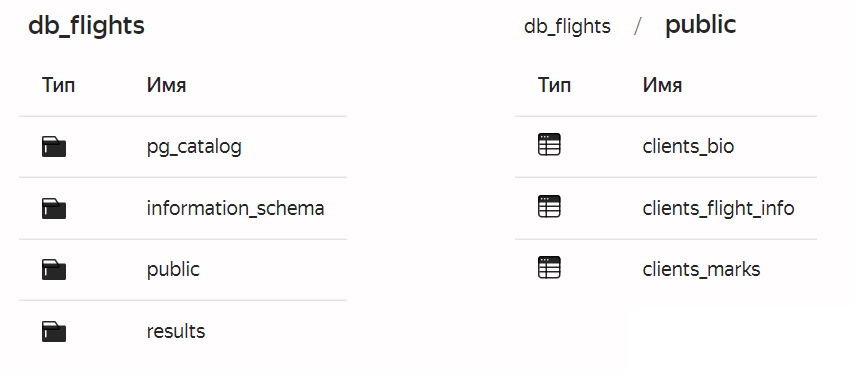

In [7]:
import psycopg2

In [9]:
# Ваш код здесь
import psycopg2
from psycopg2 import Error
import pandas as pd



try:
    # Подключение к существующей базе данных
    connection = psycopg2.connect(host="rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net", port="6432", sslmode="verify-full", dbname="db_flights", user="mlhs_student", password="mlhs_student", target_session_attrs="read-write")
    # Курсор для выполнения операций с базой данных
    cursor = connection.cursor()
    #Распечатать сведения о PostgreSQL
    #print("Информация о сервере PostgreSQL")
    #print(connection.get_dsn_parameters(), "\n")
    # Выполнение SQL-запроса
    #cursor.execute("SELECT version();")


    cursor.execute("SELECT column_name, data_type, ordinal_position FROM information_schema.columns WHERE table_name = 'clients_bio' ORDER BY ordinal_position;")
    record = cursor.fetchall()
    for row in record:
        print(row)

    cursor.execute("SELECT * FROM clients_bio LIMIT 5;")  
    # Получить результат
    #record = cursor.fetchone()
    record = cursor.fetchall()
    for row in record:
        print(row)
    #print("Вы подключены к - ", record, "\n")
    print('\n\n')

    cursor.execute("SELECT column_name, data_type, ordinal_position FROM information_schema.columns WHERE table_name = 'clients_flight_info' ORDER BY ordinal_position;")
    record = cursor.fetchall()
    for row in record:
        print(row)
    
    cursor.execute("SELECT * FROM clients_flight_info LIMIT 5;")  
    # Получить результат
    #record = cursor.fetchone()
    record = cursor.fetchall()
    for row in record:
        print(row)

    print('\n\n')

    cursor.execute("SELECT column_name, data_type, ordinal_position FROM information_schema.columns WHERE table_name = 'clients_marks' ORDER BY ordinal_position;")
    record = cursor.fetchall()
    for row in record:
        print(row)
    
    cursor.execute("SELECT * FROM clients_marks LIMIT 5;")  
    # Получить результат
    #record = cursor.fetchone()
    record = cursor.fetchall()
    for row in record:
        print(row)


    print("\n\n")


  
    command = """SELECT clients_marks.id, gender, age, "Customer Type", "Type of Travel", class, "Flight Distance", "Departure Delay in Minutes", "Arrival Delay in Minutes", "Inflight wifi service", "Departure/Arrival time convenient", "Ease of Online booking", "Gate location", "Food and drink", "Online boarding", "Seat comfort","Inflight entertainment", "On-board service", "Leg room service", "Baggage handling", "Checkin service", "Inflight service", "cleanliness", "satisfaction" FROM clients_bio INNER JOIN clients_flight_info ON clients_bio.id = clients_flight_info.id INNER JOIN clients_marks ON clients_flight_info.id = clients_marks.id LIMIT 5;"""


    cursor.execute(command)  
    # Получить результат
    #record = cursor.fetchone()
    record = cursor.fetchall()
    for row in record:
        print(row)



    command = """SELECT clients_marks.id, gender, age, "Customer Type", "Type of Travel", class, "Flight Distance", "Departure Delay in Minutes", "Arrival Delay in Minutes", "Inflight wifi service", "Departure/Arrival time convenient", "Ease of Online booking", "Gate location", "Food and drink", "Online boarding", "Seat comfort","Inflight entertainment", "On-board service", "Leg room service", "Baggage handling", "Checkin service", "Inflight service", "cleanliness", "satisfaction" FROM clients_bio INNER JOIN clients_flight_info ON clients_bio.id = clients_flight_info.id INNER JOIN clients_marks ON clients_flight_info.id = clients_marks.id;"""
    cursor.execute(command)
    record = cursor.fetchall()
    column_names = [description[0] for description in cursor.description]
    
    data = pd.DataFrame(record , columns=column_names)
    


    



except (Exception, Error) as error:
    print("Ошибка при работе с PostgreSQL", error)
finally:
    if connection:
        cursor.close()
        connection.close()
        print("Соединение с PostgreSQL закрыто")



('id', 'integer', 1)
('gender', 'text', 2)
('age', 'text', 3)
(1, 'Male', '48.0')
(2, 'Female', '35.0')
(3, 'Male', '41.0')
(4, 'Male', '50.0')
(5, 'Female', '49.0')



('id', 'integer', 1)
('Customer Type', 'text', 2)
('Type of Travel', 'text', 3)
('class', 'text', 4)
('Flight Distance', 'text', 5)
('Departure Delay in Minutes', 'text', 6)
('Arrival Delay in Minutes', 'text', 7)
(1, 'disloyal Customer', 'Business travel', 'Business', '821.0', '2.0', '5.0')
(2, 'Loyal Customer', 'Business travel', 'Business', '821.0', '26.0', '39.0')
(3, 'Loyal Customer', 'Business travel', 'Business', '853.0', '0.0', '0.0')
(4, 'Loyal Customer', 'Business travel', 'Business', '1905.0', '0.0', '0.0')
(5, 'Loyal Customer', 'Business travel', 'Business', '3470.0', '0.0', '1.0')



('id', 'integer', 1)
('Inflight wifi service', 'text', 2)
('Departure/Arrival time convenient', 'text', 3)
('Ease of Online booking', 'text', 4)
('Gate location', 'text', 5)
('Food and drink', 'text', 6)
('Online boarding', 'te

In [10]:
data.head()

id  gender   age      Customer Type   Type of Travel     class  \
0   7    Male  43.0     Loyal Customer  Business travel  Business   
1  13    Male  24.0  disloyal Customer  Business travel       Eco   
2  18  Female  61.0     Loyal Customer  Personal Travel       Eco   
3  31    Male  35.0  disloyal Customer  Business travel  Business   
4  39  Female  46.0     Loyal Customer  Business travel  Business   

  Flight Distance Departure Delay in Minutes Arrival Delay in Minutes  \
0          1963.0                        0.0                      0.0   
1           453.0                       16.0                     30.0   
2           821.0                        0.0                      0.0   
3           212.0                        0.0                      0.0   
4            67.0                        0.0                      0.0   

  Inflight wifi service  ... Online boarding Seat comfort  \
0                   3.0  ...             4.0          5.0   
1                   2.0  ...             2.0          5.0   
2                   2.0  ...             1.0          5.0   
3                   2.0  ...             2.0          2.0   
4                   3.0  ...             5.0          4.0   

  Inflight entertainment On-board service Leg room service Baggage handling  \
0                    5.0              5.0              5.0              5.0   
1                    5.0              2.0              4.0              4.0   
2                    5.0              5.0              2.0              5.0   
3                    2.0              4.0              5.0              5.0   
4                    4.0              4.0              4.0              4.0   

  Checkin service Inflight service cleanliness             satisfaction  
0             4.0              5.0         4.0                satisfied  
1             2.0              4.0         5.0  neutral or dissatisfied  
2             5.0              5.0         1.0  neutral or dissatisfied  
3             5.0              4.0         2.0  neutral or dissatisfied  
4             5.0              4.0         5.0                satisfied  

[5 rows x 24 columns]

In [11]:
data.shape

(129549, 24)

In [15]:
columns = data.columns
data.columns

Index(['id', 'gender', 'age', 'Customer Type', 'Type of Travel', 'class',
       'Flight Distance', 'Departure Delay in Minutes',
       'Arrival Delay in Minutes', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'cleanliness', 'satisfaction'],
      dtype='object')

In [17]:
df = data.copy()

In [19]:
df = df.set_index('id')

In [21]:
df.head()

gender   age      Customer Type   Type of Travel     class  \
id                                                               
7     Male  43.0     Loyal Customer  Business travel  Business   
13    Male  24.0  disloyal Customer  Business travel       Eco   
18  Female  61.0     Loyal Customer  Personal Travel       Eco   
31    Male  35.0  disloyal Customer  Business travel  Business   
39  Female  46.0     Loyal Customer  Business travel  Business   

   Flight Distance Departure Delay in Minutes Arrival Delay in Minutes  \
id                                                                       
7           1963.0                        0.0                      0.0   
13           453.0                       16.0                     30.0   
18           821.0                        0.0                      0.0   
31           212.0                        0.0                      0.0   
39            67.0                        0.0                      0.0   

   Inflight wifi service Departure/Arrival time convenient  ...  \
id                                                          ...   
7                    3.0                               3.0  ...   
13                   2.0                               2.0  ...   
18                   2.0                               5.0  ...   
31                   2.0                               2.0  ...   
39                   3.0                               3.0  ...   

   Online boarding Seat comfort Inflight entertainment On-board service  \
id                                                                        
7              4.0          5.0                    5.0              5.0   
13             2.0          5.0                    5.0              2.0   
18             1.0          5.0                    5.0              5.0   
31             2.0          2.0                    2.0              4.0   
39             5.0          4.0                    4.0              4.0   

   Leg room service Baggage handling Checkin service Inflight service  \
id                                                                      
7               5.0              5.0             4.0              5.0   
13              4.0              4.0             2.0              4.0   
18              2.0              5.0             5.0              5.0   
31              5.0              5.0             5.0              4.0   
39              4.0              4.0             5.0              4.0   

   cleanliness             satisfaction  
id                                       
7          4.0                satisfied  
13         5.0  neutral or dissatisfied  
18         1.0  neutral or dissatisfied  
31         2.0  neutral or dissatisfied  
39         5.0                satisfied  

[5 rows x 23 columns]

In [23]:
df.shape == (129549, 23)

True

In [25]:
assert df.shape == (129549, 23)

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука.

In [28]:
df_train = df[df.satisfaction != '-']

df_train.head()

gender   age      Customer Type   Type of Travel     class  \
id                                                               
7     Male  43.0     Loyal Customer  Business travel  Business   
13    Male  24.0  disloyal Customer  Business travel       Eco   
18  Female  61.0     Loyal Customer  Personal Travel       Eco   
31    Male  35.0  disloyal Customer  Business travel  Business   
39  Female  46.0     Loyal Customer  Business travel  Business   

   Flight Distance Departure Delay in Minutes Arrival Delay in Minutes  \
id                                                                       
7           1963.0                        0.0                      0.0   
13           453.0                       16.0                     30.0   
18           821.0                        0.0                      0.0   
31           212.0                        0.0                      0.0   
39            67.0                        0.0                      0.0   

   Inflight wifi service Departure/Arrival time convenient  ...  \
id                                                          ...   
7                    3.0                               3.0  ...   
13                   2.0                               2.0  ...   
18                   2.0                               5.0  ...   
31                   2.0                               2.0  ...   
39                   3.0                               3.0  ...   

   Online boarding Seat comfort Inflight entertainment On-board service  \
id                                                                        
7              4.0          5.0                    5.0              5.0   
13             2.0          5.0                    5.0              2.0   
18             1.0          5.0                    5.0              5.0   
31             2.0          2.0                    2.0              4.0   
39             5.0          4.0                    4.0              4.0   

   Leg room service Baggage handling Checkin service Inflight service  \
id                                                                      
7               5.0              5.0             4.0              5.0   
13              4.0              4.0             2.0              4.0   
18              2.0              5.0             5.0              5.0   
31              5.0              5.0             5.0              4.0   
39              4.0              4.0             5.0              4.0   

   cleanliness             satisfaction  
id                                       
7          4.0                satisfied  
13         5.0  neutral or dissatisfied  
18         1.0  neutral or dissatisfied  
31         2.0  neutral or dissatisfied  
39         5.0                satisfied  

[5 rows x 23 columns]

In [30]:
df_train.shape == (103644, 23)

True

In [32]:
assert df_train.shape == (103_644, 23)

In [34]:
df_test = df[df.satisfaction == '-'].drop('satisfaction', axis=1)
df_test.head()

gender   age   Customer Type   Type of Travel     class Flight Distance  \
id                                                                             
55     Male  36.0  Loyal Customer  Business travel  Business          3655.0   
79   Female  70.0  Loyal Customer  Personal Travel       Eco           108.0   
126    Male  66.0  Loyal Customer  Personal Travel       Eco           562.0   
199  Female  60.0  Loyal Customer  Business travel  Business          3756.0   
263    Male  43.0  Loyal Customer  Personal Travel  Business           802.0   

    Departure Delay in Minutes Arrival Delay in Minutes Inflight wifi service  \
id                                                                              
55                        40.0                     71.0                   1.0   
79                        50.0                     41.0                   5.0   
126                       88.0                     84.0                   2.0   
199                       36.0                     24.0                   4.0   
263                        0.0                      0.0                   1.0   

    Departure/Arrival time convenient  ... Food and drink Online boarding  \
id                                     ...                                  
55                                1.0  ...            1.0             3.0   
79                                4.0  ...            4.0             4.0   
126                               5.0  ...            5.0             2.0   
199                               4.0  ...            2.0             4.0   
263                               2.0  ...            2.0             3.0   

    Seat comfort Inflight entertainment On-board service Leg room service  \
id                                                                          
55           3.0                    3.0              3.0              3.0   
79           4.0                    3.0              3.0              0.0   
126          5.0                    5.0              3.0              5.0   
199          5.0                    4.0              4.0              4.0   
263          3.0                    2.0              2.0              1.0   

    Baggage handling Checkin service Inflight service cleanliness  
id                                                                 
55               1.0             4.0              3.0         2.0  
79               3.0             5.0              3.0         5.0  
126              2.0             5.0              5.0         5.0  
199              4.0             5.0              4.0         5.0  
263              2.0             3.0              2.0         1.0  

[5 rows x 22 columns]

In [36]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид.

In [39]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), df_train.satisfaction, test_size=0.3, random_state=42)

In [41]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

### **Задание 10 (0.25 балла)**

- Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)
- Заполните пропуски в данных наиболее часто встречающимся значением.
Помните про правильность заполнения.
- Выведите основные статистики по числовым и категориальным столбцам таблицы
- Сделайте **текстовый** вывод о распределениях значений признаков

In [44]:
# Ваш код здесь

In [46]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72550 entries, 2031 to 28513
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   gender                             72550 non-null  object
 1   age                                72550 non-null  object
 2   Customer Type                      72550 non-null  object
 3   Type of Travel                     72550 non-null  object
 4   class                              72550 non-null  object
 5   Flight Distance                    72550 non-null  object
 6   Departure Delay in Minutes         72550 non-null  object
 7   Arrival Delay in Minutes           72550 non-null  object
 8   Inflight wifi service              72550 non-null  object
 9   Departure/Arrival time convenient  72550 non-null  object
 10  Ease of Online booking             72550 non-null  object
 11  Gate location                      72550 non-null  object
 12  Food a

In [48]:
for column in X_train.columns:
    print(column)
    print(X_train[column].value_counts())
    #for j, k in X_train[column].value_counts().items():
        #print(j, k)
    print("\n")

gender
gender
Female    36816
Male      35734
Name: count, dtype: int64


age
age
39.0     2058
25.0     1925
40.0     1775
41.0     1749
44.0     1747
         ... 
126.0       1
472.0       1
399.0       1
175.0       1
106.0       1
Name: count, Length: 217, dtype: int64


Customer Type
Customer Type
Loyal Customer       59354
disloyal Customer    13144
nan                     52
Name: count, dtype: int64


Type of Travel
Type of Travel
Business travel    49984
Personal Travel    22496
nan                   70
Name: count, dtype: int64


class
class
Business    34727
Eco         32546
Eco Plus     5211
nan            66
Name: count, dtype: int64


Flight Distance
Flight Distance
337.0      470
594.0      283
404.0      283
2475.0     252
447.0      251
          ... 
1339.0       1
1169.0       1
2980.0       1
41500.0      1
730.0        1
Name: count, Length: 3897, dtype: int64


Departure Delay in Minutes
Departure Delay in Minutes
0.0      40776
1.0       2065
2.0       1574
3.0

In [50]:
X_train.columns

Index(['gender', 'age', 'Customer Type', 'Type of Travel', 'class',
       'Flight Distance', 'Departure Delay in Minutes',
       'Arrival Delay in Minutes', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'cleanliness'],
      dtype='object')

In [52]:
numerical = ['age', 'Flight Distance', 'Departure Delay in Minutes', \
             'Arrival Delay in Minutes', 'Inflight wifi service', 'Departure/Arrival time convenient', \
             'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', \
             'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'cleanliness']
categorical = ['gender', 'Customer Type', 'Type of Travel', 'class']
numerical

['age',
 'Flight Distance',
 'Departure Delay in Minutes',
 'Arrival Delay in Minutes',
 'Inflight wifi service',
 'Departure/Arrival time convenient',
 'Ease of Online booking',
 'Gate location',
 'Food and drink',
 'Online boarding',
 'Seat comfort',
 'Inflight entertainment',
 'On-board service',
 'Leg room service',
 'Baggage handling',
 'Checkin service',
 'Inflight service',
 'cleanliness']

есть 'nan' везде
'0.0' 29   в age
все значение более 100 в age суть мусор, так как их единицы (1-7).

In [55]:
print('Вывод мод:')
for column in X_train.columns:
    mode_column = X_train[column].mode()[0]
    X_train[column].fillna(mode_column, inplace=True)

    X_train[column] = X_train[column].apply(lambda x: mode_column if x == 'nan' else x)
    
    X_val[column] = X_val[column].apply(lambda x: mode_column if x == 'nan' else x)

    if column == 'age':
        X_train[column] = X_train[column].apply(lambda x: mode_column if x == '0.0' else x)

        X_val[column] = X_val[column].apply(lambda x: mode_column if x == '0.0' else x)
        
    
    if column in numerical:
        X_train[column] = X_train[column].astype(float)

        X_val[column] = X_val[column].astype(float)
        
    
    print(column, mode_column)
    

Вывод мод:
gender Female
age 39.0
Customer Type Loyal Customer
Type of Travel Business travel
class Business
Flight Distance 337.0
Departure Delay in Minutes 0.0
Arrival Delay in Minutes 0.0
Inflight wifi service 3.0
Departure/Arrival time convenient 4.0
Ease of Online booking 3.0
Gate location 3.0
Food and drink 4.0
Online boarding 4.0
Seat comfort 4.0
Inflight entertainment 4.0
On-board service 4.0
Leg room service 4.0
Baggage handling 4.0
Checkin service 4.0
Inflight service 4.0
cleanliness 4.0


In [57]:
X_train.describe()

age  Flight Distance  Departure Delay in Minutes  \
count  72550.000000     72550.000000                72550.000000   
mean      40.114445      1329.018332                   15.859366   
std       20.642639      4764.369357                   70.861937   
min        7.000000         0.000000                    0.000000   
25%       27.000000       413.000000                    0.000000   
50%       40.000000       844.000000                    0.000000   
75%       51.000000      1744.000000                   12.000000   
max      544.000000    379620.000000                 9282.000000   

       Arrival Delay in Minutes  Inflight wifi service  \
count              72550.000000           72550.000000   
mean                  16.645968               2.733687   
std                   97.990293               1.362172   
min                    0.000000               0.000000   
25%                    0.000000               2.000000   
50%                    0.000000               3.000000   
75%                   13.000000               4.000000   
max                11760.000000              45.000000   

       Departure/Arrival time convenient  Ease of Online booking  \
count                       72550.000000            72550.000000   
mean                            3.065017                2.761006   
std                             1.552254                1.414843   
min                             0.000000                0.000000   
25%                             2.000000                2.000000   
50%                             3.000000                3.000000   
75%                             4.000000                4.000000   
max                            45.000000               28.000000   

       Gate location  Food and drink  Online boarding  Seat comfort  \
count   72550.000000    72550.000000     72550.000000  72550.000000   
mean        2.982688        3.209318         3.256513      3.445665   
std         1.316648        1.349963         1.372739      1.346077   
min         0.000000        0.000000         0.000000      0.000000   
25%         2.000000        2.000000         2.000000      2.000000   
50%         3.000000        3.000000         3.000000      4.000000   
75%         4.000000        4.000000         4.000000      5.000000   
max        36.000000       36.000000        32.000000     45.000000   

       Inflight entertainment  On-board service  Leg room service  \
count            72550.000000      72550.000000      72550.000000   
mean                 3.362150          3.383101          3.352364   
std                  1.360862          1.333758          1.360180   
min                  0.000000          0.000000          0.000000   
25%                  2.000000          2.000000          2.000000   
50%                  4.000000          4.000000          4.000000   
75%                  4.000000          4.000000          4.000000   
max                 40.000000         45.000000         36.000000   

       Baggage handling  Checkin service  Inflight service   cleanliness  
count      72550.000000     72550.000000      72550.000000  72550.000000  
mean           3.630255         3.309056          3.640234      3.291178  
std            1.227853         1.293114          1.215114      1.343302  
min            0.000000         0.000000          0.000000      0.000000  
25%            3.000000         3.000000          3.000000      2.000000  
50%            4.000000         3.000000          4.000000      3.000000  
75%            5.000000         4.000000          5.000000      4.000000  
max           40.000000        45.000000         36.000000     45.000000

In [59]:
X_train.describe(include = 'object')

gender   Customer Type   Type of Travel     class
count    72550           72550            72550     72550
unique       2               2                2         3
top     Female  Loyal Customer  Business travel  Business
freq     36816           59406            50054     34793

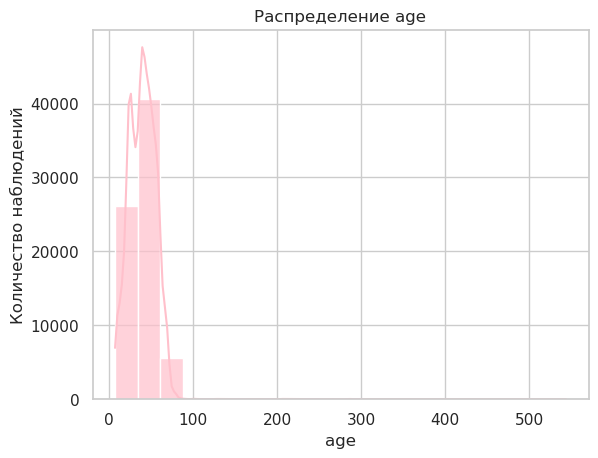

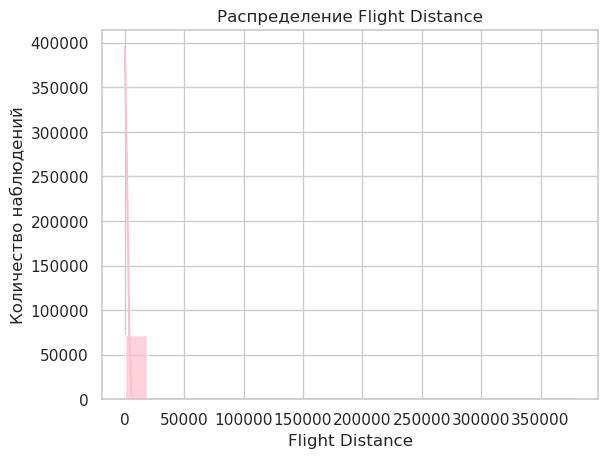

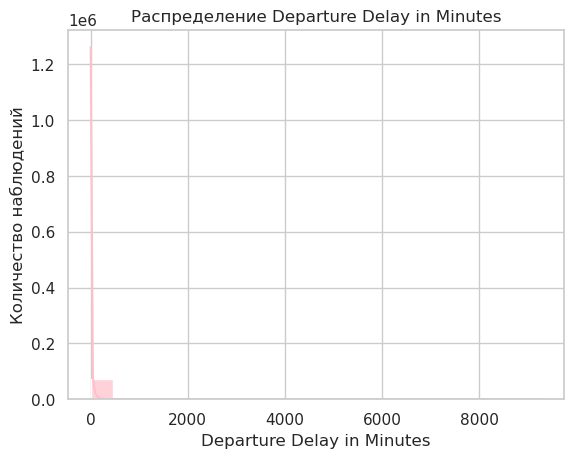

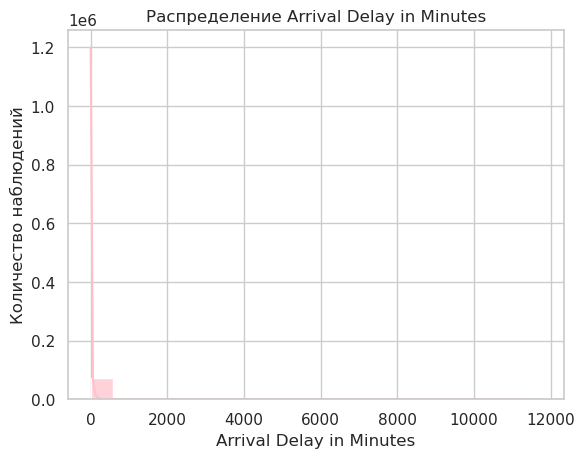

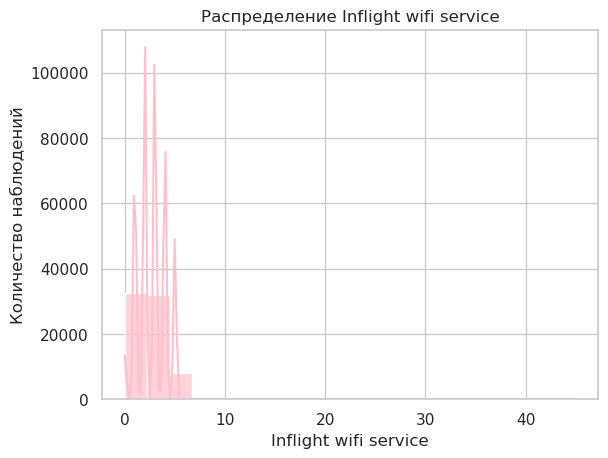

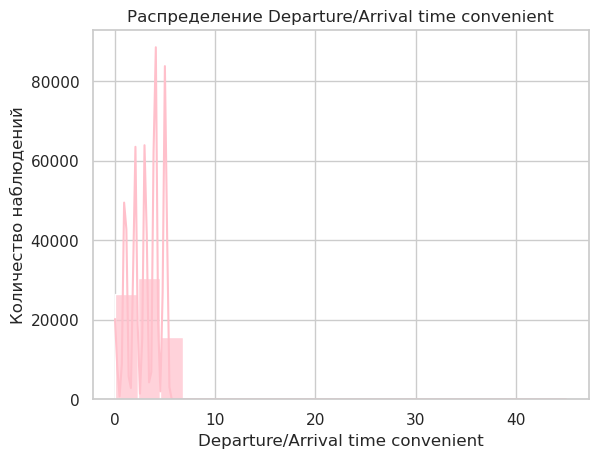

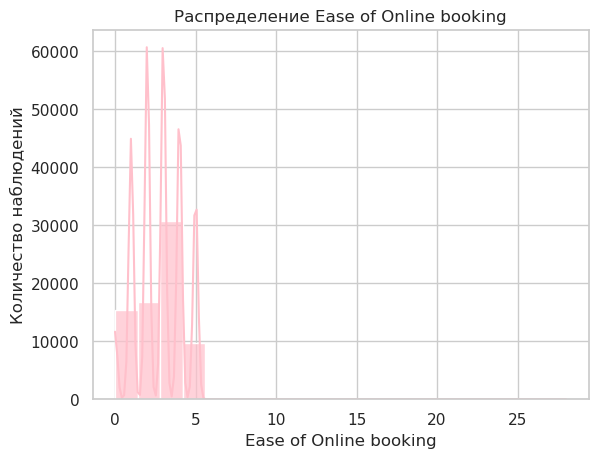

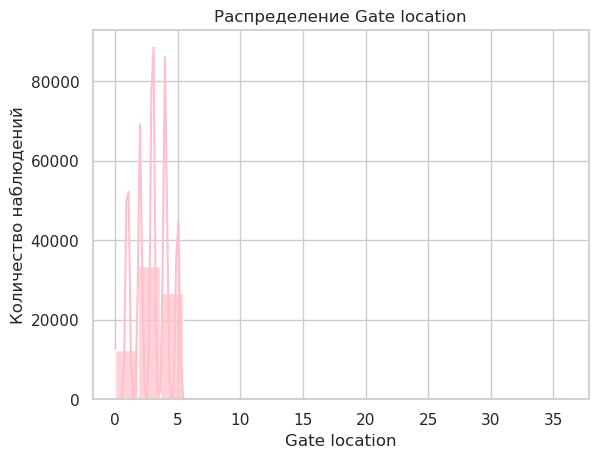

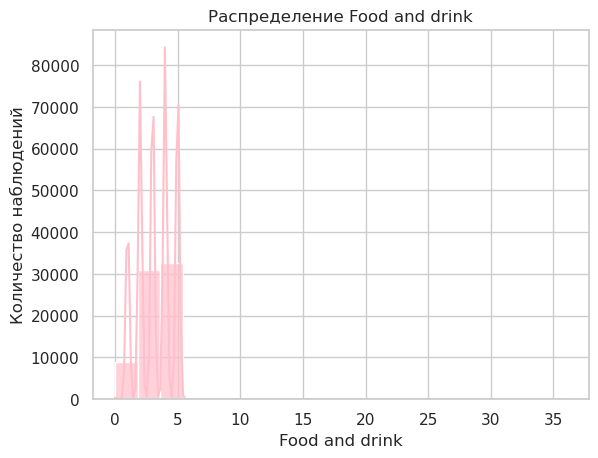

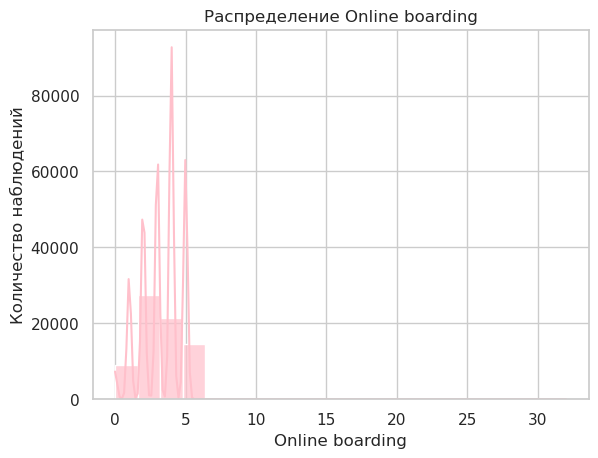

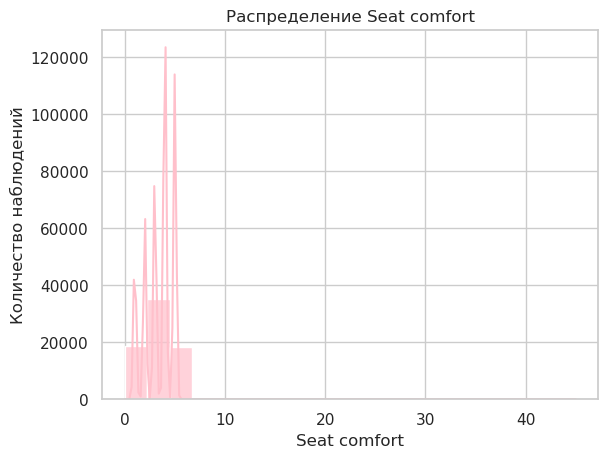

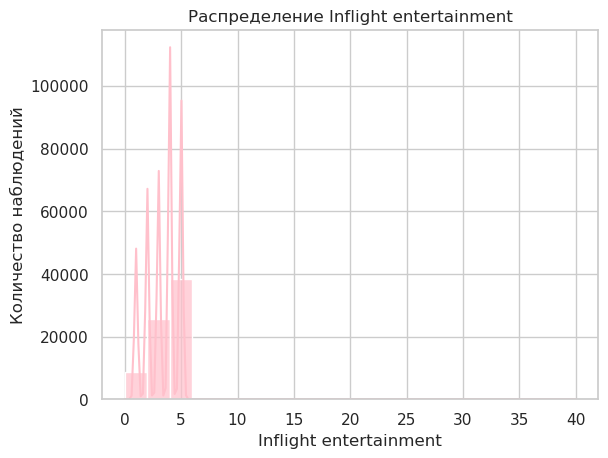

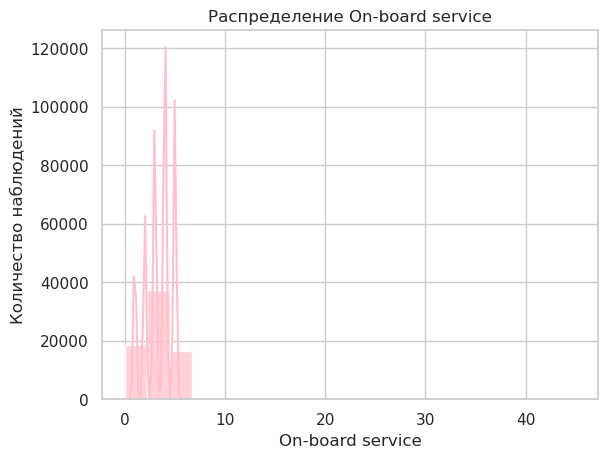

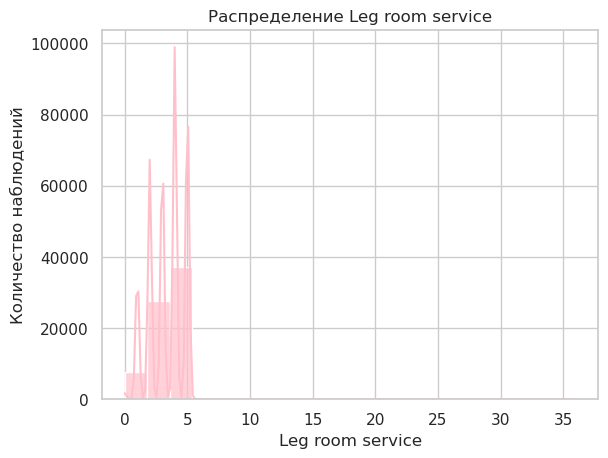

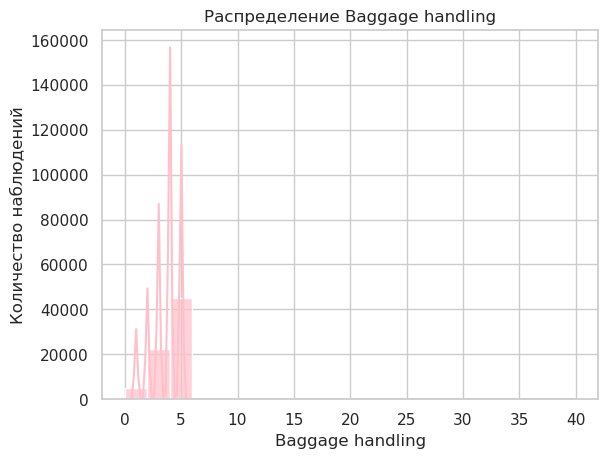

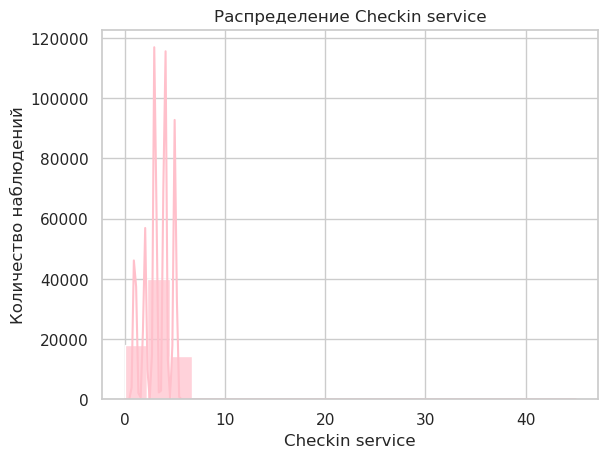

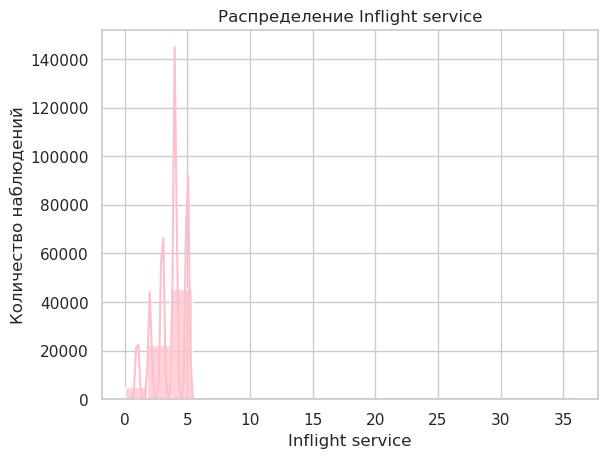

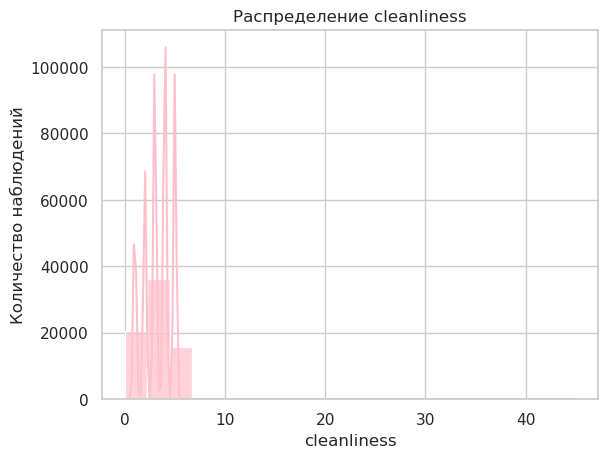

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = X_train.select_dtypes([int, float]).columns

def draw_hist_plot(df, col):
    #plt.figure(figsize = (5, 10))
    sns.histplot(data = df, x = col, bins=20, color = 'pink', kde = True, alpha = 0.7)
    plt.title(f'Распределение {col}')
    plt.xlabel(f'{col}')
    plt.ylabel('Количество наблюдений')
    plt.show()


for i in numeric_cols:
    draw_hist_plot(X_train, i)

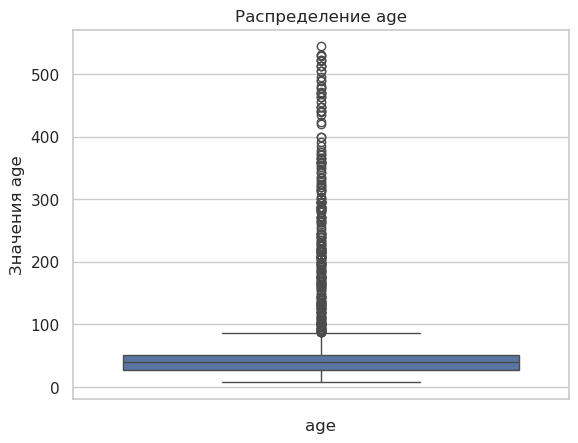

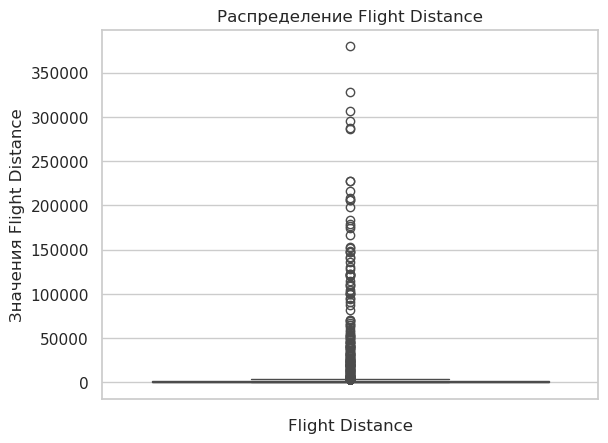

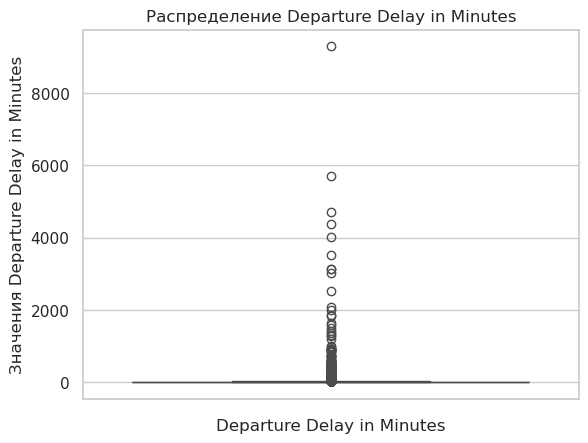

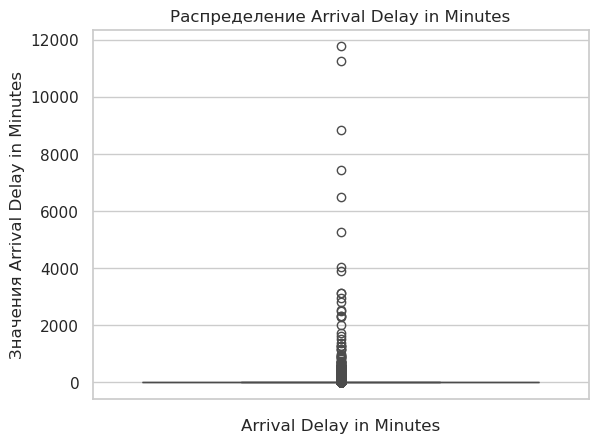

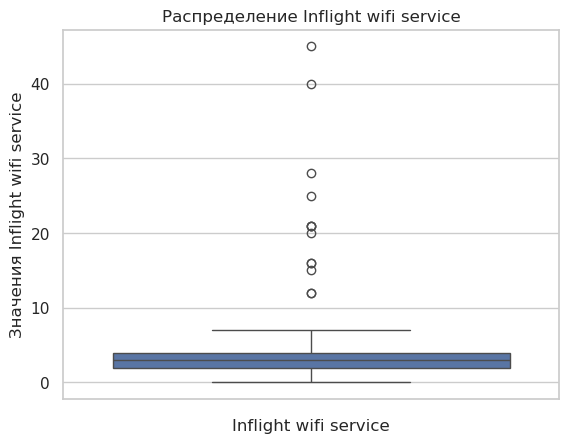

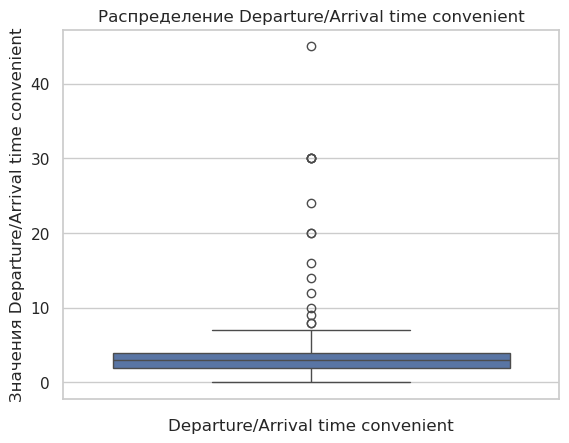

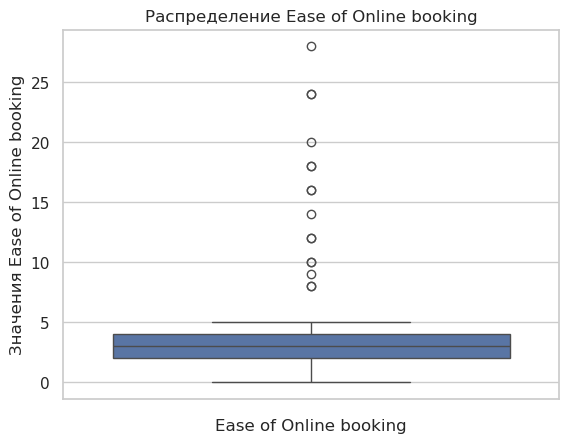

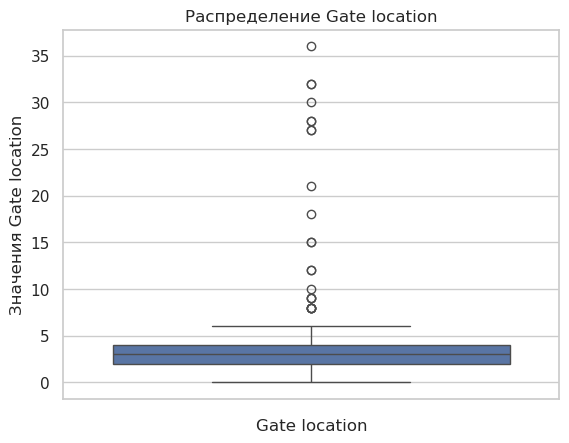

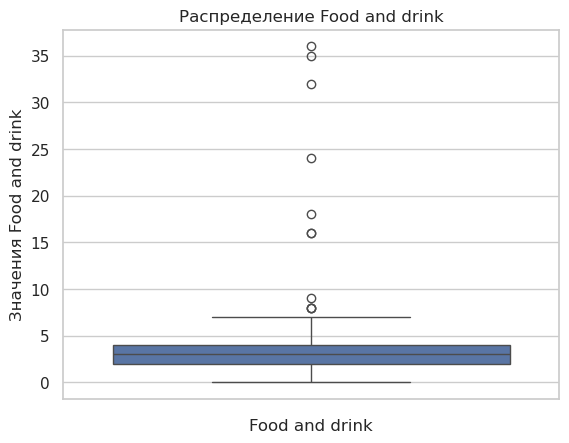

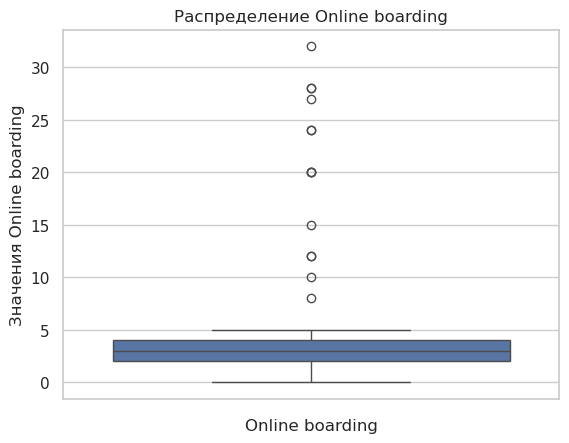

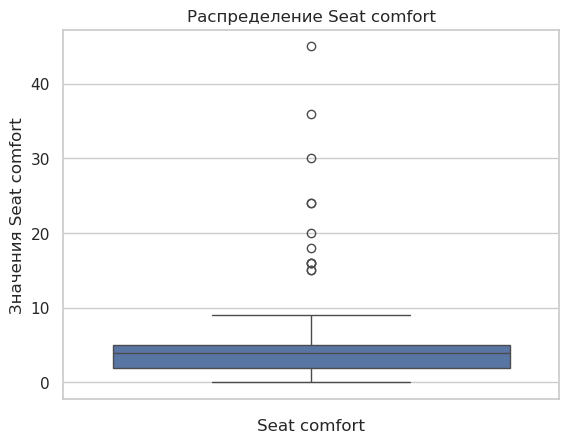

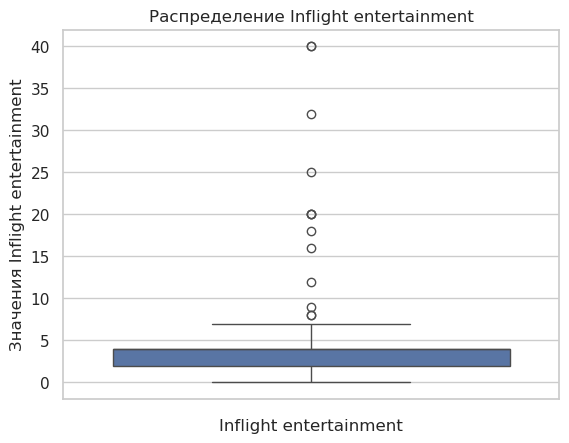

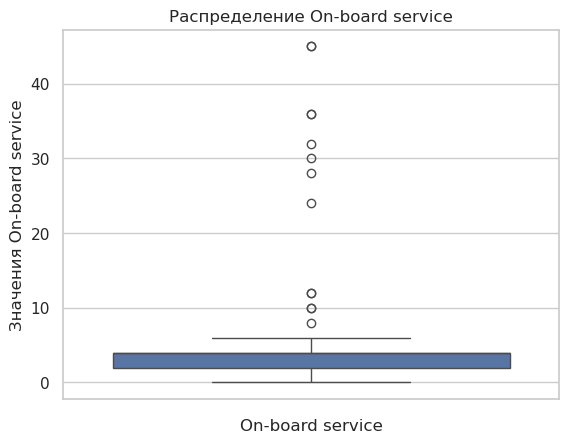

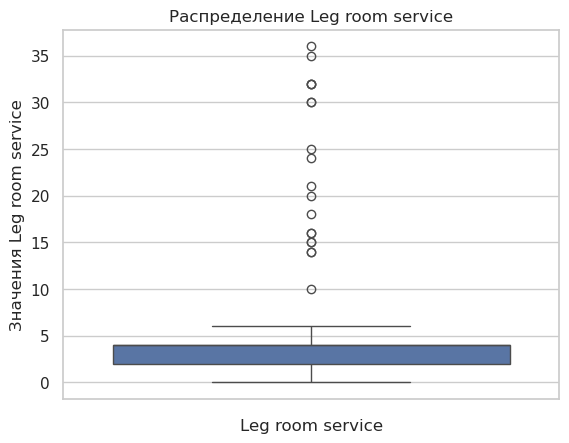

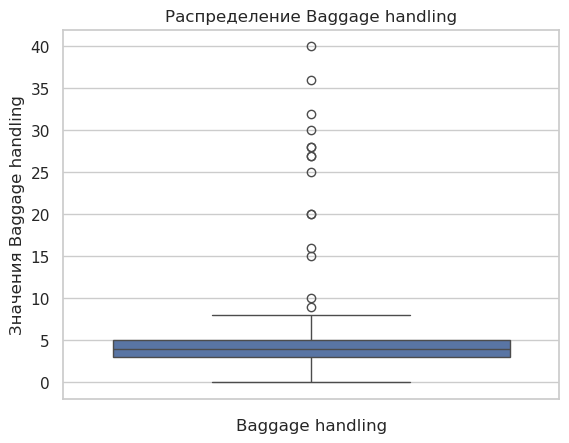

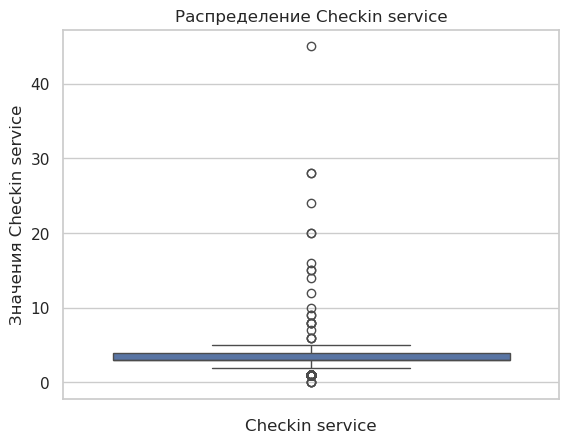

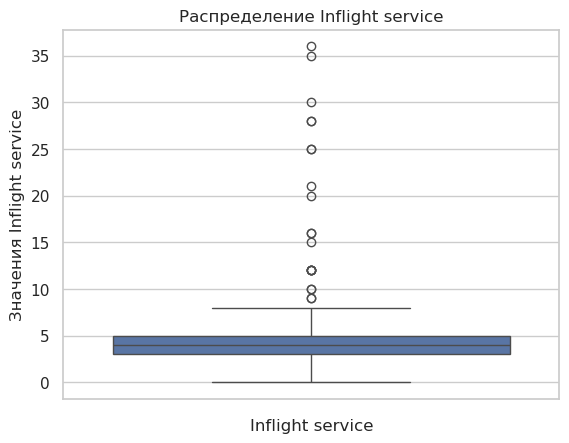

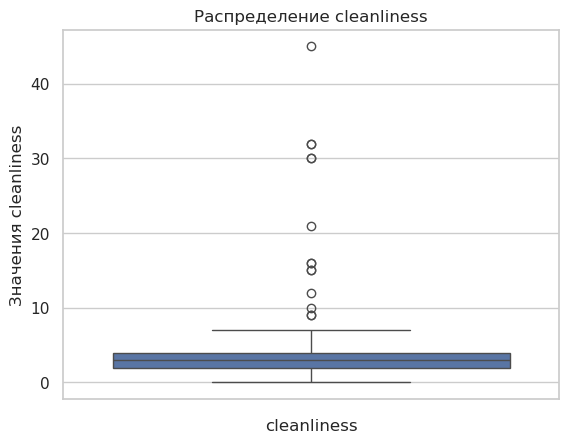

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = X_train.select_dtypes([int, float]).columns
for col in numeric_cols:
    sns.boxplot(data = X_train[col])
    plt.title(f'Распределение {col}')
    plt.xlabel(f'{col}')
    plt.ylabel(f'Значения {col}')
    plt.show()

`Ваш ответ здесь`


По форме гистограмм выше мы видим, что распределение большинства признаков близко к нормальному, у некоторых признаков лог-нормальное распределение (если качество будет плохим, то можно буди попробовать логарифмировать признаки со смещением в распределении).
BoxPlot показывает, что в наблюдениях по каждому признаку есть явные выбросы (шум). Предлагаю удалить шумные данные в следуюещем разделе.

### **Задание 11. (2 балла)**

Осуществите предобработку датасета для обучения **полностью самостоятельно**, на основе вашего опыта из прошлых дз и изученной теории. Обязательно **комментируйте** каждое действие.

**Примечание:**

В данном задании ваша задача в том числе убедить ревьюера в достаточности предобработки.

In [65]:
# Ваш код здесь     y_train      X_train

X_train_ed = X_train.copy()
y_train_ed = y_train.copy()


numeric_cols = X_train.select_dtypes([int, float]).columns
for col in numeric_cols:
    IQR = X_train[col].quantile(0.75) - X_train[col].quantile(0.25)
    h = X_train[col].quantile(0.75) + 1.5 * IQR
    l = X_train[col].quantile(0.25) - 1.5 * IQR
    print(col, l, h)

    y_train_ed = y_train_ed.drop(X_train_ed[(X_train_ed[col] >= h) | (X_train_ed[col] <= l)].index)
    X_train_ed = X_train_ed.drop(X_train_ed[(X_train_ed[col] >= h) | (X_train_ed[col] <= l)].index)
    


age -9.0 87.0
Flight Distance -1583.5 3740.5
Departure Delay in Minutes -18.0 30.0
Arrival Delay in Minutes -19.5 32.5
Inflight wifi service -1.0 7.0
Departure/Arrival time convenient -1.0 7.0
Ease of Online booking -1.0 7.0
Gate location -1.0 7.0
Food and drink -1.0 7.0
Online boarding -1.0 7.0
Seat comfort -2.5 9.5
Inflight entertainment -1.0 7.0
On-board service -1.0 7.0
Leg room service -1.0 7.0
Baggage handling 0.0 8.0
Checkin service 1.5 5.5
Inflight service 0.0 8.0
cleanliness -1.0 7.0


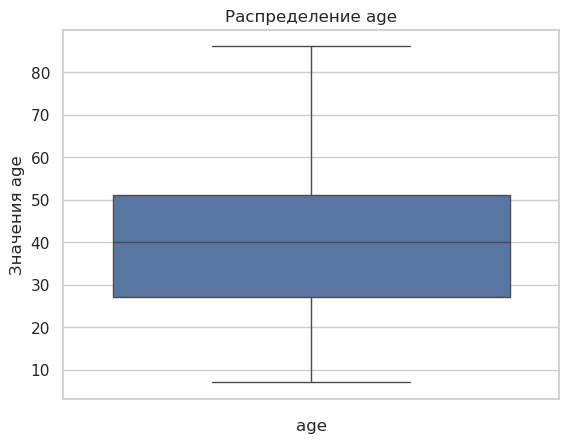

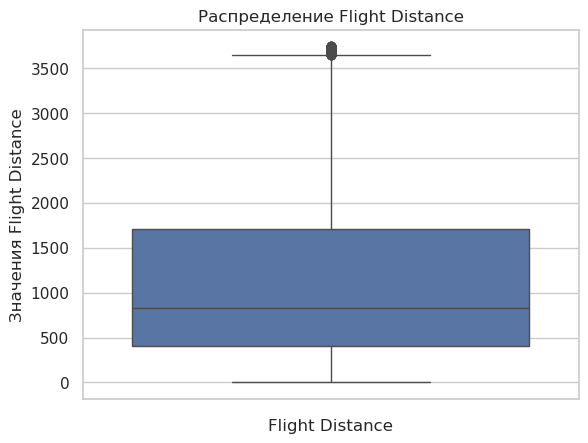

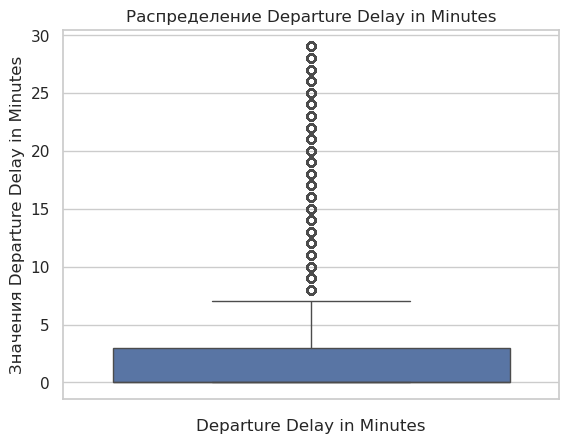

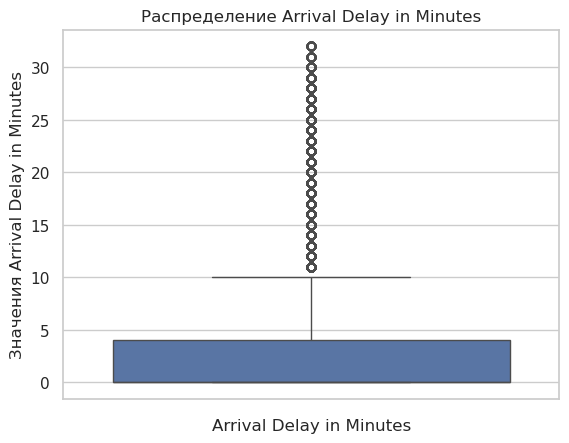

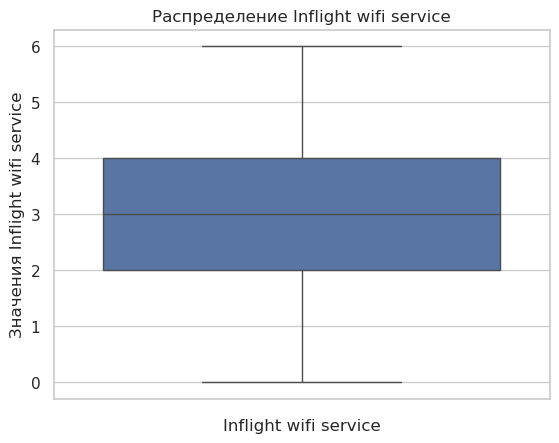

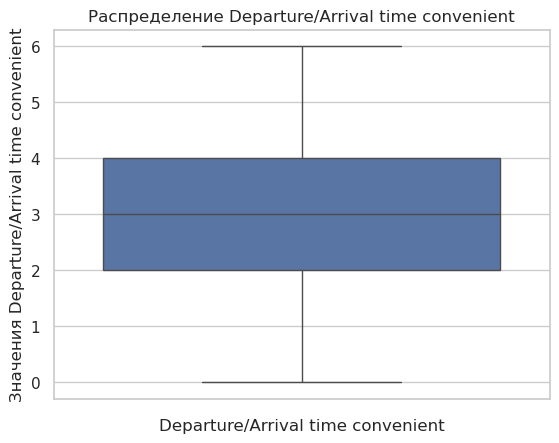

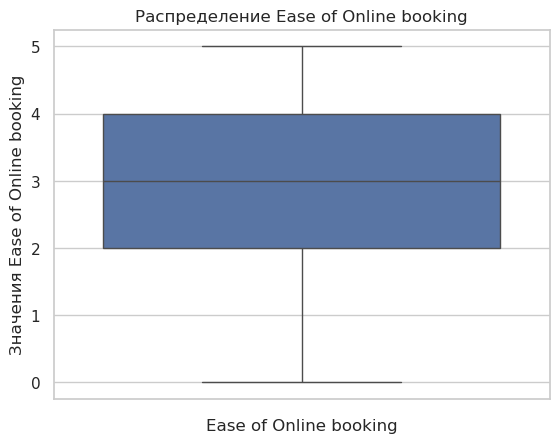

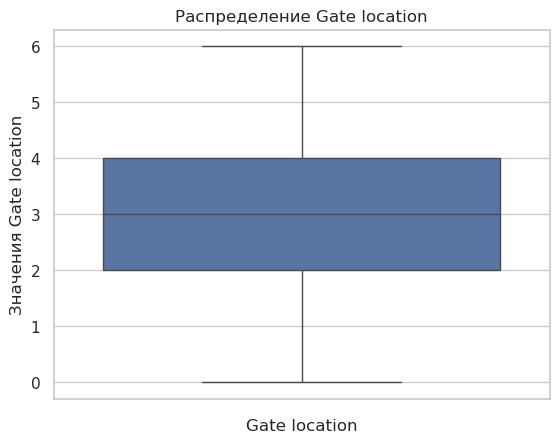

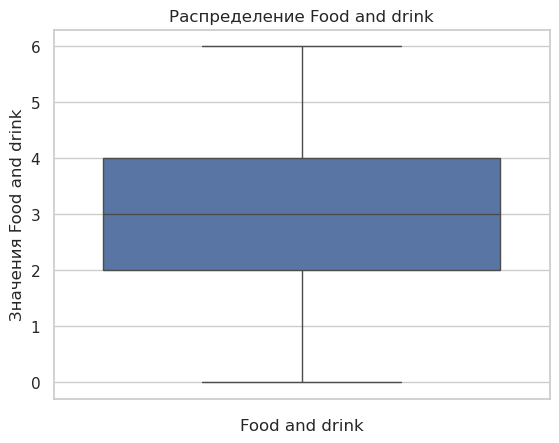

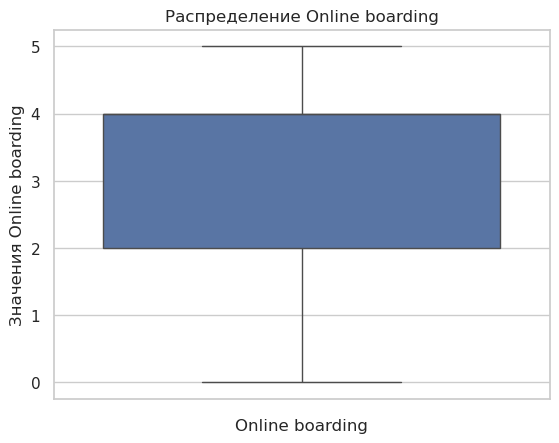

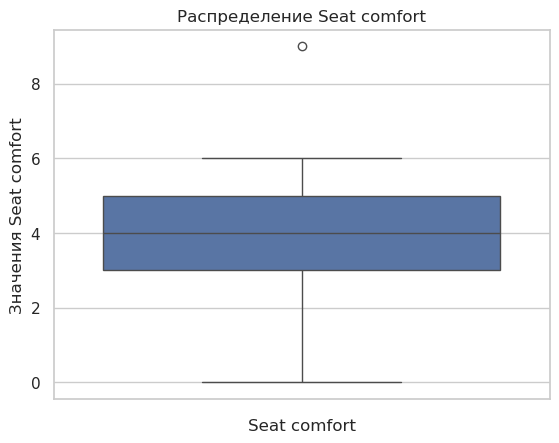

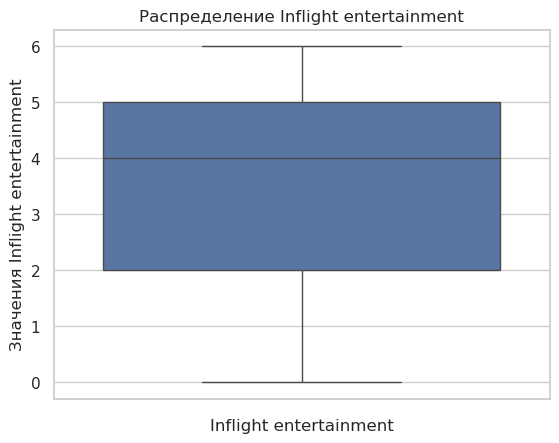

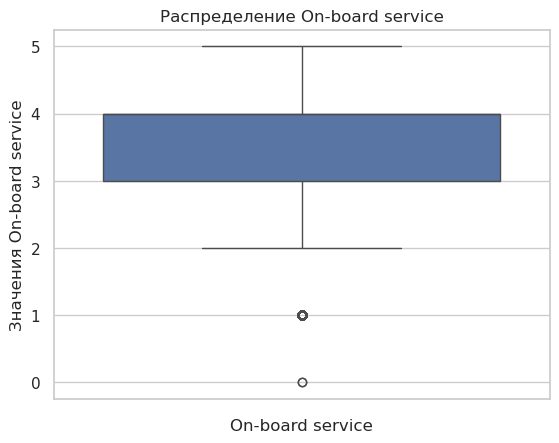

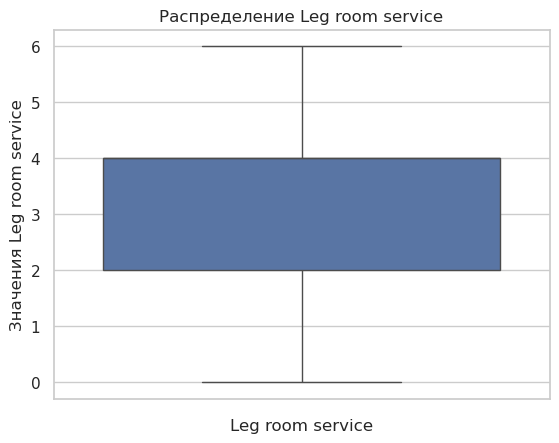

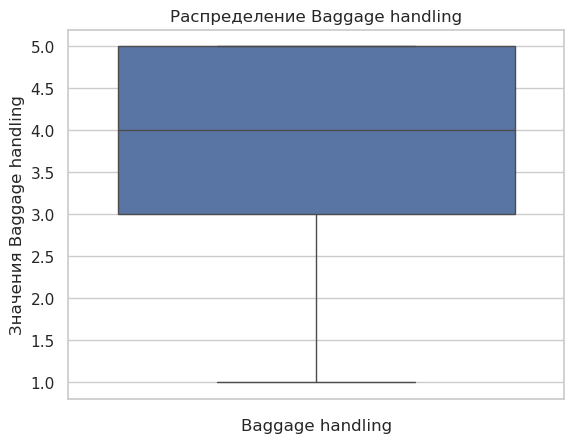

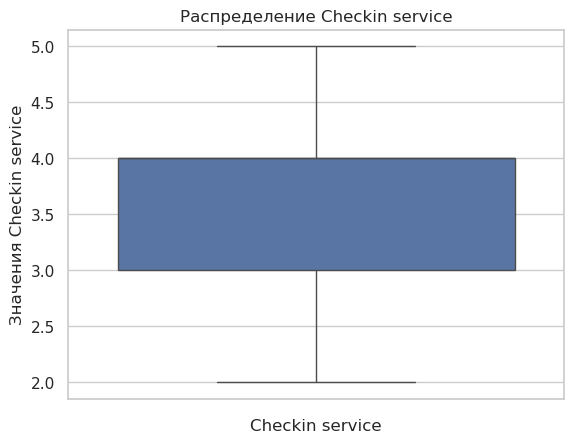

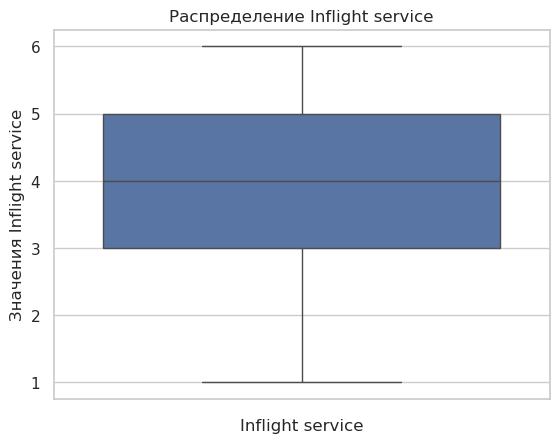

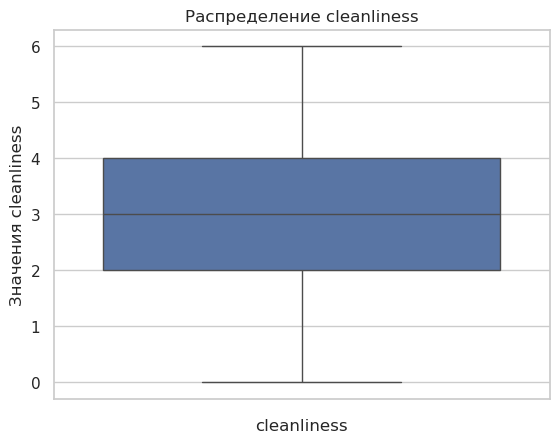

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = X_train_ed.select_dtypes([int, float]).columns
for col in numeric_cols:
    sns.boxplot(data = X_train_ed[col])
    plt.title(f'Распределение {col}')
    plt.xlabel(f'{col}')
    plt.ylabel(f'Значения {col}')
    plt.show()

In [69]:
X_train_ed.shape

(51547, 22)

In [71]:
y_train_ed.shape

(51547,)

In [73]:
X_train.shape

(72550, 22)

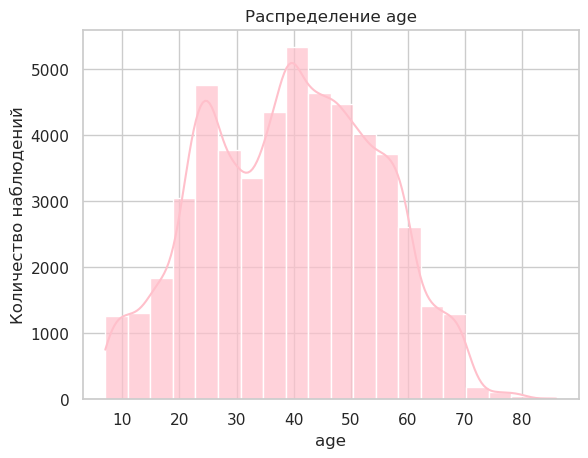

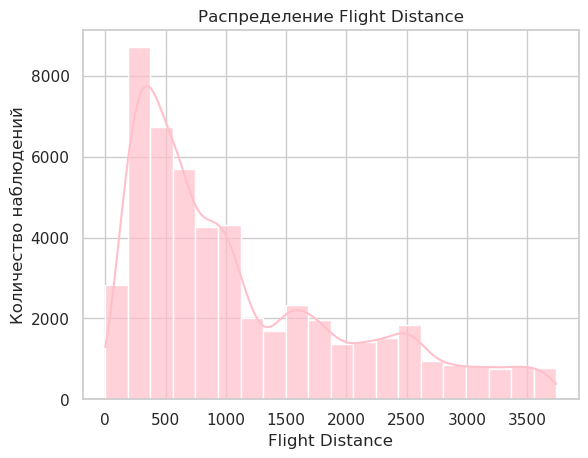

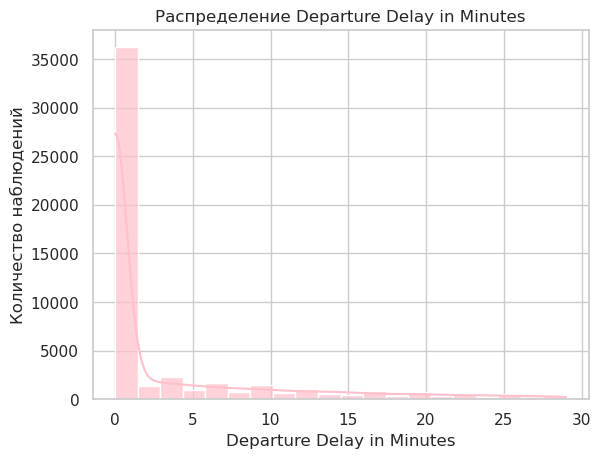

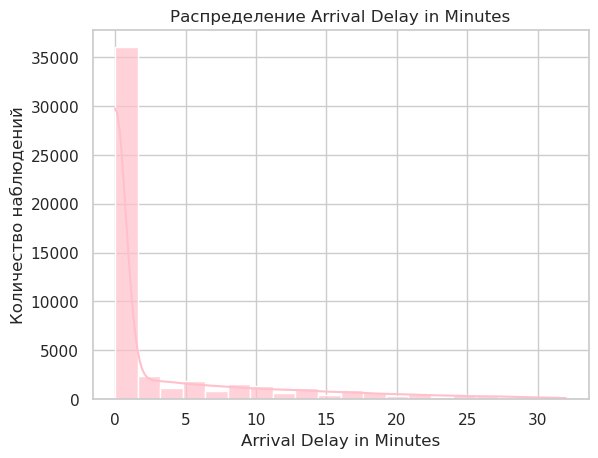

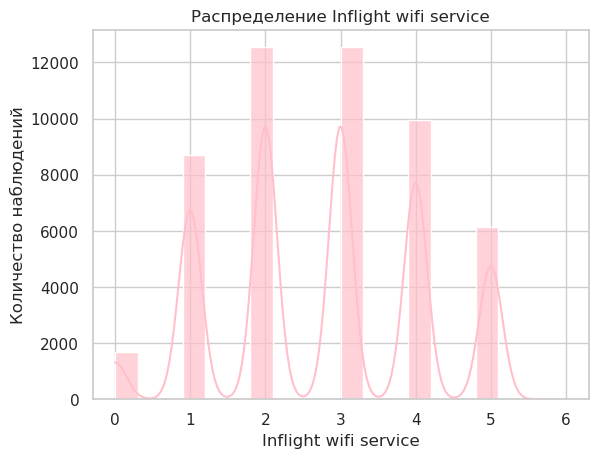

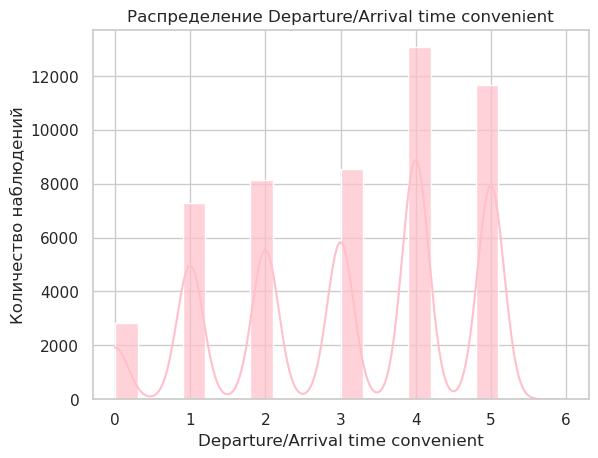

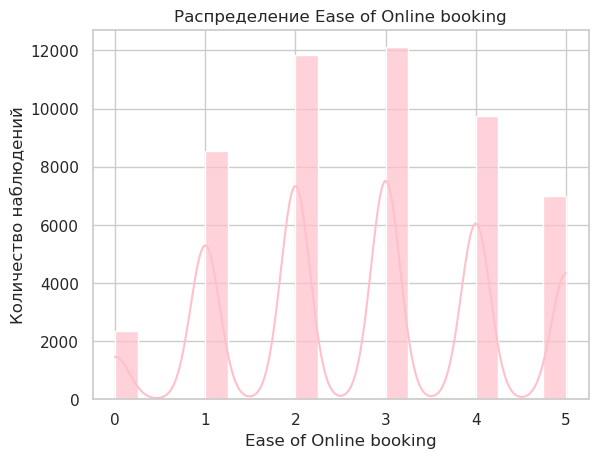

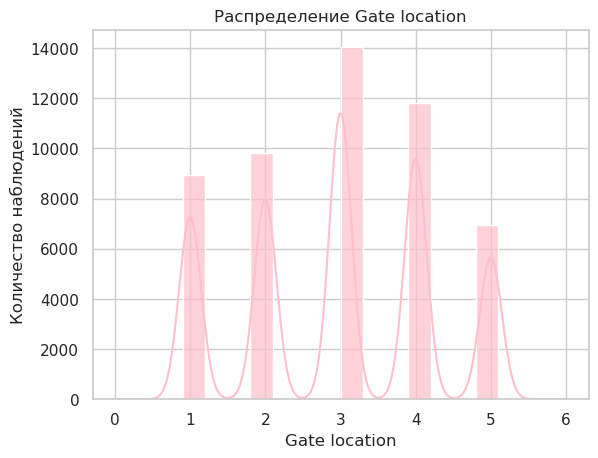

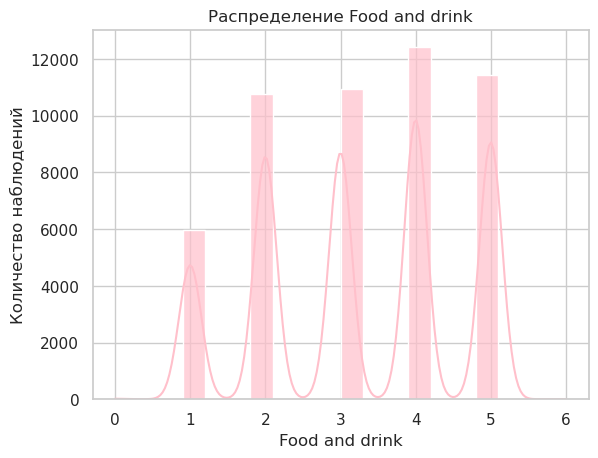

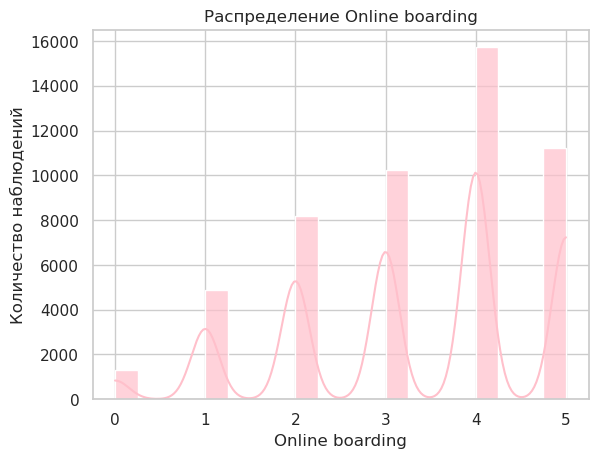

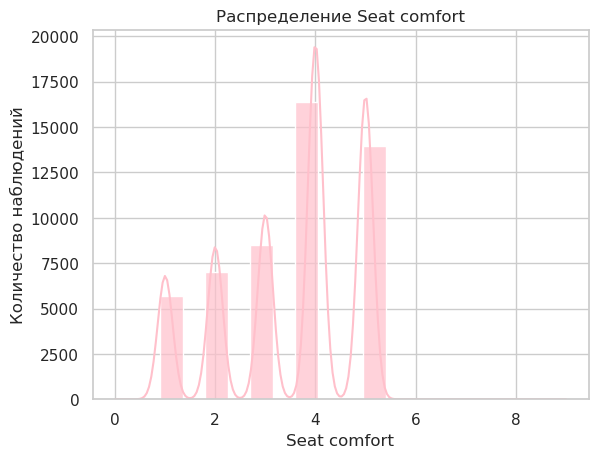

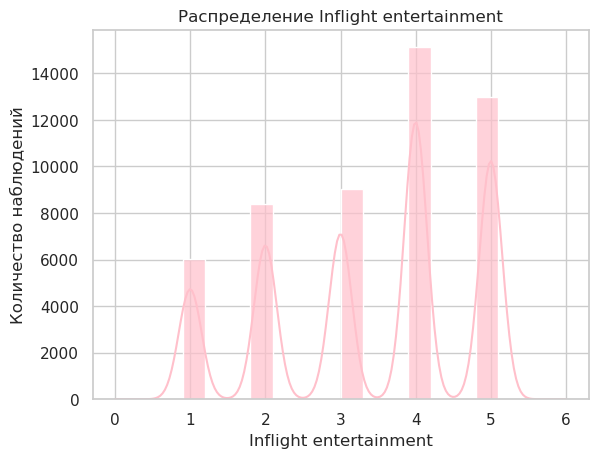

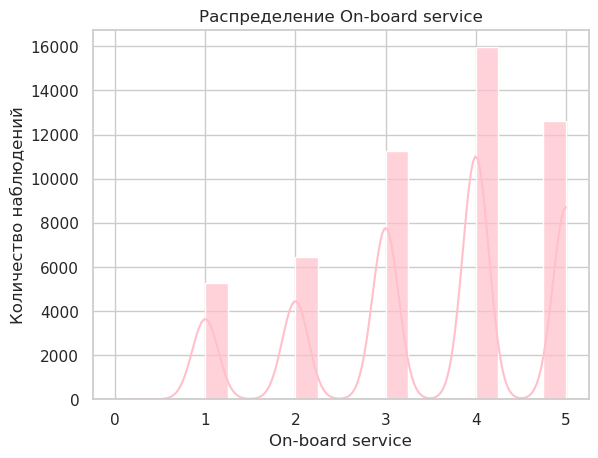

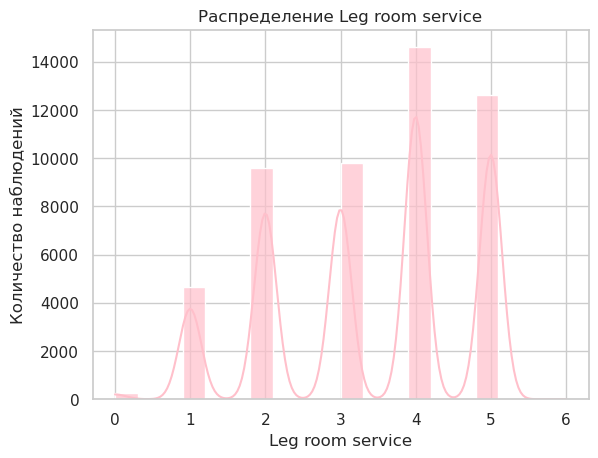

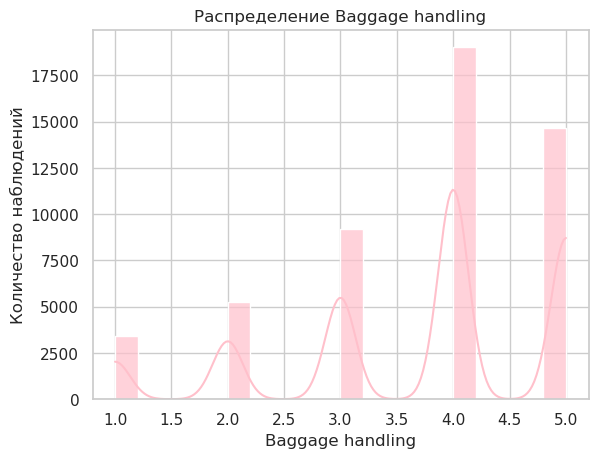

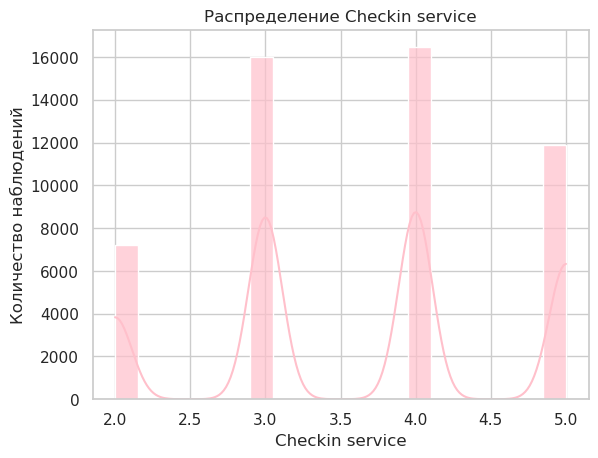

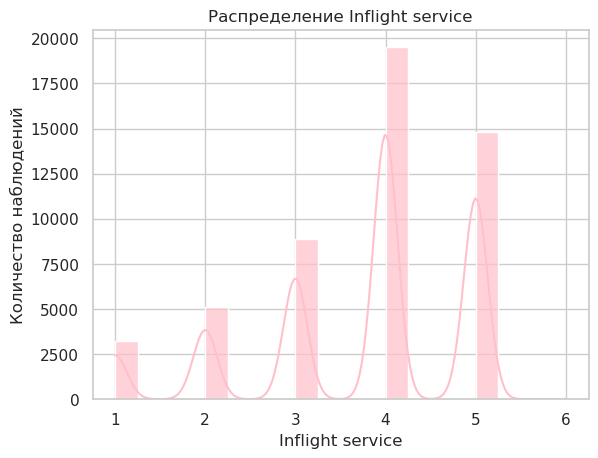

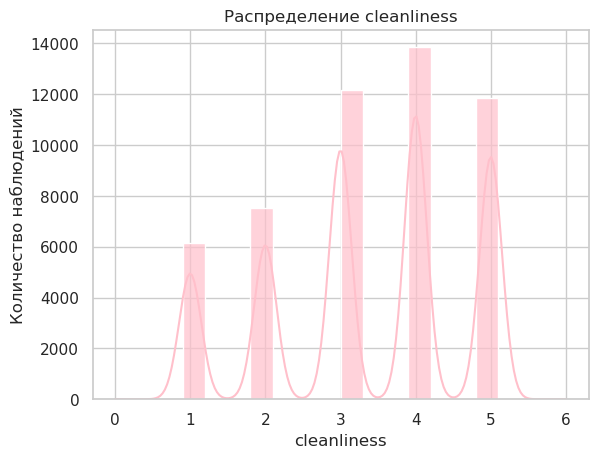

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = X_train_ed.select_dtypes([int, float]).columns

def draw_hist_plot(df, col):
    #plt.figure(figsize = (5, 10))
    sns.histplot(data = df, x = col, bins=20, color = 'pink', kde = True, alpha = 0.7)
    plt.title(f'Распределение {col}')
    plt.xlabel(f'{col}')
    plt.ylabel('Количество наблюдений')
    plt.show()


for i in numeric_cols:
    draw_hist_plot(X_train_ed, i)

In [76]:
X_train_ed.head()

gender   age      Customer Type   Type of Travel     class  \
id                                                                  
2031   Female  29.0  disloyal Customer  Business travel  Business   
11597  Female  45.0     Loyal Customer  Business travel  Business   
74668    Male   8.0     Loyal Customer  Personal Travel       Eco   
31602  Female  48.0     Loyal Customer  Personal Travel       Eco   
51518  Female  25.0  disloyal Customer  Business travel       Eco   

       Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                                             
2031             785.0                         0.0                       0.0   
11597           3269.0                         0.0                       0.0   
74668           1431.0                         0.0                       0.0   
31602            602.0                         0.0                       0.0   
51518            651.0                         0.0                       0.0   

       Inflight wifi service  Departure/Arrival time convenient  ...  \
id                                                               ...   
2031                     2.0                                2.0  ...   
11597                    0.0                                0.0  ...   
74668                    3.0                                1.0  ...   
31602                    4.0                                5.0  ...   
51518                    5.0                                0.0  ...   

       Food and drink  Online boarding  Seat comfort  Inflight entertainment  \
id                                                                             
2031              4.0              2.0           3.0                     4.0   
11597             2.0              2.0           1.0                     3.0   
74668             5.0              3.0           5.0                     5.0   
31602             2.0              5.0           4.0                     4.0   
51518             2.0              5.0           2.0                     2.0   

       On-board service  Leg room service  Baggage handling  Checkin service  \
id                                                                             
2031                4.0               3.0               5.0              4.0   
11597               3.0               3.0               3.0              5.0   
74668               2.0               5.0               2.0              2.0   
31602               4.0               4.0               2.0              3.0   
51518               1.0               1.0               2.0              3.0   

       Inflight service  cleanliness  
id                                    
2031                5.0          4.0  
11597               3.0          1.0  
74668               1.0          5.0  
31602               4.0          3.0  
51518               1.0          2.0  

[5 rows x 22 columns]

In [77]:
categorical

['gender', 'Customer Type', 'Type of Travel', 'class']

In [78]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

X_val_encoded = X_val.copy()

for i in categorical:
    encoder =  LabelEncoder()
    X_train_ed[i] = encoder.fit(X_train_ed[i]).transform(X_train_ed[i])
    X_val_encoded[i] = encoder.transform(X_val_encoded[i])

In [79]:
X_train_ed.head()

gender   age  Customer Type  Type of Travel  class  Flight Distance  \
id                                                                           
2031        0  29.0              1               0      0            785.0   
11597       0  45.0              0               0      0           3269.0   
74668       1   8.0              0               1      1           1431.0   
31602       0  48.0              0               1      1            602.0   
51518       0  25.0              1               0      1            651.0   

       Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                            
2031                          0.0                       0.0   
11597                         0.0                       0.0   
74668                         0.0                       0.0   
31602                         0.0                       0.0   
51518                         0.0                       0.0   

       Inflight wifi service  Departure/Arrival time convenient  ...  \
id                                                               ...   
2031                     2.0                                2.0  ...   
11597                    0.0                                0.0  ...   
74668                    3.0                                1.0  ...   
31602                    4.0                                5.0  ...   
51518                    5.0                                0.0  ...   

       Food and drink  Online boarding  Seat comfort  Inflight entertainment  \
id                                                                             
2031              4.0              2.0           3.0                     4.0   
11597             2.0              2.0           1.0                     3.0   
74668             5.0              3.0           5.0                     5.0   
31602             2.0              5.0           4.0                     4.0   
51518             2.0              5.0           2.0                     2.0   

       On-board service  Leg room service  Baggage handling  Checkin service  \
id                                                                             
2031                4.0               3.0               5.0              4.0   
11597               3.0               3.0               3.0              5.0   
74668               2.0               5.0               2.0              2.0   
31602               4.0               4.0               2.0              3.0   
51518               1.0               1.0               2.0              3.0   

       Inflight service  cleanliness  
id                                    
2031                5.0          4.0  
11597               3.0          1.0  
74668               1.0          5.0  
31602               4.0          3.0  
51518               1.0          2.0  

[5 rows x 22 columns]

In [80]:
pd.DataFrame(y_train_ed).value_counts()

satisfaction           
neutral or dissatisfied    27496
satisfied                  24051
Name: count, dtype: int64

In [81]:
y_train_ed = y_train_ed.apply(lambda x: 1 if x == 'satisfied' else 0)

In [89]:
pd.DataFrame(y_train_ed).value_counts()

satisfaction
0               27496
1               24051
Name: count, dtype: int64

In [91]:
pd.DataFrame(y_val).value_counts()

satisfaction           
neutral or dissatisfied    17649
satisfied                  13445
Name: count, dtype: int64

In [93]:
y_val_ed = y_val.apply(lambda x: 1 if x == 'satisfied' else 0)

In [95]:
pd.DataFrame(y_val_ed).value_counts()

satisfaction
0               17649
1               13445
Name: count, dtype: int64

### **Задание 12. (0.25 балла)**

- Обучите самописное дерево и Random Forest с базовыми гиперпараметрами. Выведите `f1-score`.

In [265]:
# Ваш код здесь  X_train_ed    y_train_ed
# X_val_encoded, y_val_ed

In [273]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score


rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_ed, y_train_ed)

# X_val, y_val 

y_pred_rf = rf_classifier.predict(X_val_encoded)
f1_rf = f1_score(y_val_ed, y_pred_rf)
print(f"F1-Score для Random Forest Classifier: {f1_rf:.4f}")

F1-Score для Random Forest Classifier: 0.9527


In [383]:
from sklearn.metrics import f1_score

feature_types = ['real' for i in range(X_train_ed.shape[1])]
dt_classifier = DecisionTree(feature_types)
dt_classifier.fit(np.array(X_train_ed), np.array(y_train_ed))
y_pred_dt = dt_classifier.predict(np.array(X_val_encoded))
f1_dt = f1_score(y_val_ed, y_pred_dt)
print(f"F1-Score для самописного дерева решений: {f1_dt:.4f}")

F1-Score для самописного дерева решений: 0.9294


### **Задание 13. (0.4 баллa)**

- Попробуйте подобрать оптимальные гиперпараметры леса и дерева (если реализовали их в бонусе), используя [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).
- Сравните качество полученных моделей и выберите лучшую. Лучшую модель сохраните в pickle.

**Важно:**  

Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [127]:
# Ваш код здесь
#самописное дерево c момощью RandomizedSearchCV обучил на 3000 наблюдений
#так как требуется много времени на обучение. RFC далее обучил на всех данных

In [135]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint, uniform

feature_types = ['real' for i in range(X_train_ed.shape[1])]

model_DT = DecisionTree(feature_types)

param_dist = {
    'max_depth': randint(1, 20),
    'min_samples_split': randint(5, 50),
    'min_samples_leaf': randint(3, 50)
}


randomized_search_DT = RandomizedSearchCV(model_DT, param_distributions=param_dist,
                                       n_iter=10, cv=3,
                                       scoring='f1', n_jobs=-1,
                                       verbose = 3)


randomized_search_DT.fit(np.array(X_train_ed[:3000]), np.array(y_train_ed[:3000]))

best_model_DT = randomized_search_DT.best_estimator_

print(f"Лучшие параметры самописного DT: {randomized_search_DT.best_params_}")
print(f"Лучший балл кросс-валидации самописного DT: {randomized_search_DT.best_score_:.4f}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Лучшие параметры самописного DT: {'max_depth': 9, 'min_samples_leaf': 11, 'min_samples_split': 16}
Лучший балл кросс-валидации самописного DT: 0.9109


In [78]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint, uniform

model_RFC = RandomForestClassifier()
uniform

param_dist = {
    'n_estimators': randint(1, 1000),
    'max_depth': randint(1, 700),
    'min_samples_split': randint(1, 400),
    'min_samples_leaf': uniform(0, 1.0),
    'bootstrap': [True, False]
}


randomized_search_RFC = RandomizedSearchCV(model_RFC, param_distributions=param_dist,
                                       n_iter=4000, cv=5,
                                       scoring='f1', n_jobs=-1,
                                       verbose = 1)


randomized_search_RFC.fit(X_train_ed, y_train_ed)

best_model_RFC = randomized_search_RFC.best_estimator_

print(f"Лучшие параметры: {randomized_search_RFC.best_params_}")
print(f"Лучший балл кросс-валидации: {randomized_search_RFC.best_score_:.4f}")

Fitting 5 folds for each of 4000 candidates, totalling 20000 fits
Лучшие параметры: {'bootstrap': False, 'max_depth': 561, 'min_samples_leaf': 0.00035474385102207684, 'min_samples_split': 164, 'n_estimators': 234}
Лучший балл кросс-валидации: 0.9406


In [80]:
# качество лучшей модели на валидационной выборке
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

y_pred_brf = best_model_RFC.predict(X_val_encoded)
f1_brf = f1_score(y_val_ed, y_pred_brf)
print(f"F1-Score для Random Forest Classifier: {f1_brf:.4f}")

F1-Score для Random Forest Classifier: 0.9363


In [82]:
# сохранение модели в pickle
import pickle
from sklearn.ensemble import RandomForestClassifier

with open('best_model_RFC.pkl', 'wb') as file:
    pickle.dump(best_model_RFC, file)


In [84]:
with open('best_model_RFC.pkl', 'rb') as file:
    loaded_model = pickle.load(file)


y_pred_brf = loaded_model.predict(X_val_encoded)
f1_brf = f1_score(y_val_ed, y_pred_brf)
print(f"F1-Score для Random Forest Classifier: {f1_brf:.4f}")

F1-Score для Random Forest Classifier: 0.9363


### **Задание 14. Анализ моделей (0.1 балла)**

- Отобразите`feature_importances_` вашего лучшего случайного леса;
- Проанализируйте, какие признаки оказались важными?

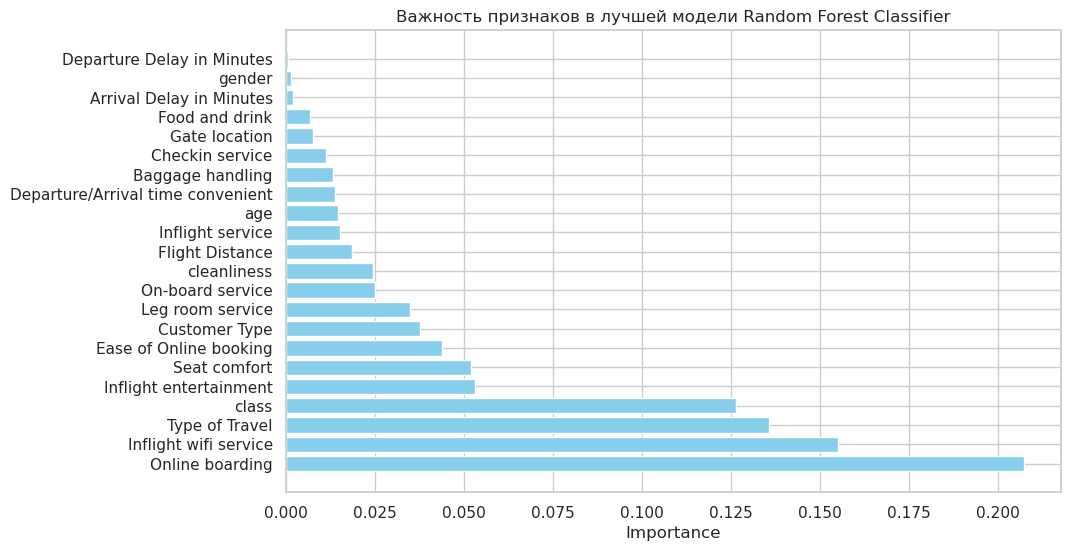

In [86]:
# Ваш код здесь
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

importances = best_model_RFC.feature_importances_

feature_names = X_train_ed.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Важность признаков в лучшей модели Random Forest Classifier')
plt.show()

`Ваш ответ здесь. `

Самые важные признаки по значимости:

**важность выше 0.125** -
1) 'Online boarding
2) 'Inflight wifi service'
3) 'Type of Travel'
4) 'class'
   
**важность выше 0.025** -
  
5) 'Inflight entertainment'
6) 'Seat comfort'
7) 'Ease of Online booking'
8) 'Customer Type'
9) 'Leg room service'

Ранжирование моделью признаков выглядет осмысленно и с точки зрения поьребителя.


In [88]:
feature_names

Index(['gender', 'age', 'Customer Type', 'Type of Travel', 'class',
       'Flight Distance', 'Departure Delay in Minutes',
       'Arrival Delay in Minutes', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'cleanliness'],
      dtype='object')

### **Задание 15. (0.25 балла)**
- Интерпретируйте важности признаков с помощью SHAP.
- Опишите полученый график

**Важно:** Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

**Вам может помочь:** [Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

In [122]:
#!pip install shap -q
#!pip install eli5 -q
#!pip install catboost -q

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [235]:
#import eli5
import shap
import lime

explainer = shap.TreeExplainer(best_model_RFC)
shap_values = explainer.shap_values(X_val_encoded)

In [240]:
shap_values_1 = np.array([[j[1] for j in i] for i in shap_values]) 

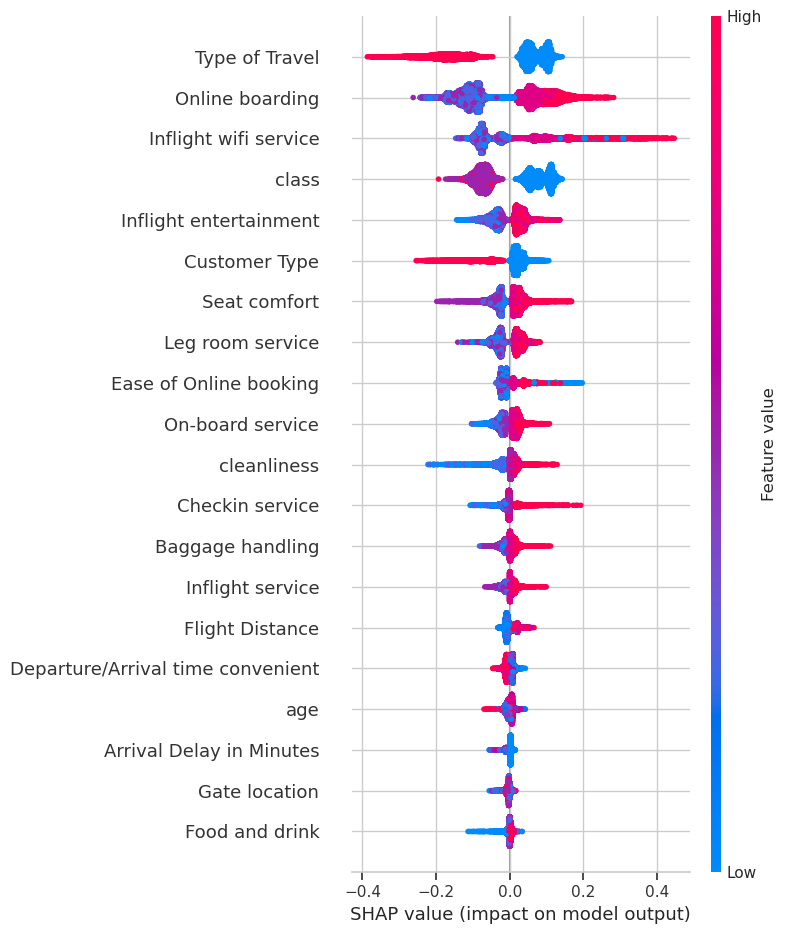

In [242]:
shap.summary_plot(shap_values_1, X_val_encoded)

`Ваш ответ здесь. `


Каждая горизонтальная линия соответствует одному признаку, и на этой линии отмечаются точки, соответствующие наблюдениям: кордината точки на линии соответствует SHAP value, цвет точки - значению признака. Если в каком-то участке линии не хватает места для всех точек, линия начинает расти в ширину. Таким образом, для каждого признака схема представляет собой слившееся множество точек, по одной точке для каждого примера

Ранжирование признаков по SHAP value схоже с ранжированием feature_importances_.
Очевидное влияние на удовлетворённость полётом имеет Type of Travel. Данный признак разделяет все наблюдения на два класса. Чем ниже значение признака, тем ниже SHAP value меньше нуля и потребитель удовлетворён полётом. При высоких значения признака имеем большие положительные SHAP value и неудовлетворённость полётом.

Очевидное влияние на удовлетворённость полётом имеет Online Boarding. Чем выше значение призанка - тем выше SHAP value и удовлетворённость клиента. Но в некорых контекстах высокое значение признака может означать и неудовлетворённость полётом (таких наблюдений немного).


Можно также заметить, что большинство SHAP values имеют симметричные или схожие хвосты больше и меньше нуля.
Это означает, что в зависимости от значений признаков (больше или меньше) изменяется удовлетворённость полётом. Т.е. нет признаков,  которые бы не влияли на какое-то значение целевого класса.

### **Задание 16. (0.25 балла)**

- Интерпретируйте важности признаков для одного прогноза с помощью LIME;
- Опишите полученный график для выбранного наблюдения

In [ ]:
!pip install lime -q

In [ ]:
# Ваш код здесь

In [244]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_val_encoded.values, feature_names=X_val_encoded.columns.values.tolist(), mode='classification')
explanation = explainer.explain_instance(X_val_encoded.values[100], best_model_RFC.predict_proba, num_features=22)

explanation.show_in_notebook(show_table=True)

LIME создает локальную упрощенную модель (обычно линейную) вокруг конкретной точки данных (экземпляра), для которого мы получаем объяснение.
LIME создает искусственные данные вокруг интересующей точки, немного изменяя значения признаков.
Модель машинного обучения предсказывает результаты для этих искусственных данных.
LIME оценивает, как каждый признак влияет на предсказание для конкретной точки.


`Ваш ответ здесь. `

Ранжирование признаков LIME в целом схоже с двумя полученными выше ранжированиеми SHAP и feature_importances_.

Признаки: На оси Y отображаются признаки, которые внесли наибольший вклад в предсказание модели для данного экземпляра:
1) 'Type of Travel'
2) 'Inflight wifi service'
3) 'class'
4) 'Online boarding


Влияние признаков: Ось X показывает, как каждый признак влияет на предсказание модели:
Отрицательное влияние: Признаки ('Type of Travel', 'Inflight wifi service', 'class', 'Online boarding' ...), которые уменьшают предсказание модели (подталкивают к классу '0' неудовлетворённость полётом) отображаются слева от нулевой линии. Эти признаки выделяются синим цветом.
Длина баров: Длина баров показывает силу влияния признака на предсказание. Чем длиннее бар, тем сильнее влияние признака.


Положительное влияние: Признаки, которые увеличивают предсказание модели (подталкивают модель к определенному классу или значению) отображаются справа от нулевой линии. Эти признаки выделяются оранжевым цветом ('Customer Type', 'Seat Comfort' ...).

Значения признаков: Напротив каждого признака указано конкретное значение этого признака в данном экземпляре данных.

Вероятность класса: На графике сверху указывается вероятность класса, предсказанная моделью для данного экземпляра данных. 0.99 - класс '0'. Неудовлетворённость полётом.

## Котобонус!

0.25 балла

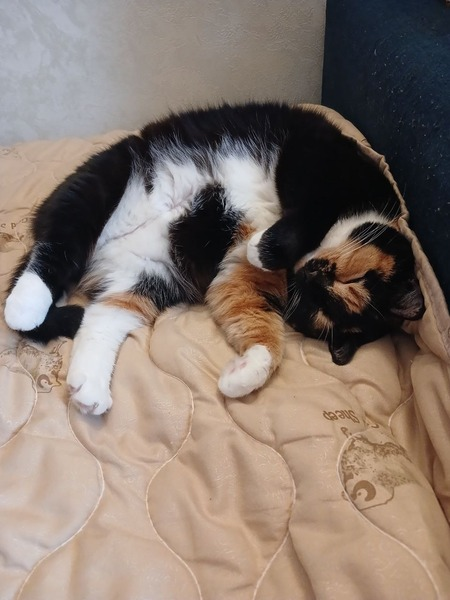

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?

отличное задание :) но очень большое